<a href="https://colab.research.google.com/github/Zoneti/fiap-postech-tech-challenge4/blob/main/TC4_Grupo44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tech Challenge 4 - 2DTAT


---


**Grupo 44**

Rodrigo da Silva Moreira - RM 350817

Gabriel Zoneti Figueira Peres - RM 351089

# Importação das Bibliotecas

In [1]:
!pip install pycountry_convert
!pip install statsforecast==1.5.0
!pip install pmdarima
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.7/231.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00


In [2]:
# Bibliotecas a serem utilizadas

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import pickle
from datetime import datetime
from math import sqrt

import os
import pycountry_convert as pc
import warnings
import missingno as msno

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA, WindowAverage
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from prophet import Prophet

from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Definição de funções

In [3]:
# Função para pegar o continente em que um país se encontra

def country_to_continent(country_name):
    try:
      country_alpha2 = pc.country_name_to_country_alpha2(country_name)
      country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
      country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
      return country_continent_name
    except:
      return np.NaN

In [4]:
def aplicando_eventos(row):
    for anos, eventos in dic_eventos.items():
        if isinstance(anos, tuple):
            if row['Ano'] >= anos[0] and row['Ano'] <= anos[1]:
                return eventos
        elif row['Ano'] == anos:
            return eventos
    return 'Sem Eventos'

In [5]:
def createDir(dir):
  if not os.path.exists(dir):
    os.mkdir(dir)

In [6]:
def calc_wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [7]:
def calc_mae (y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / len(y_true)

In [8]:
def teste_ADF(y_value):
  result_adfuller = adfuller(y_value)
  print('Teste ADF')
  print('H0 = hipótese nula (não é estacionária)')
  print('H1 = hipótese alternativa (é estacionária)')

  print(f'Teste estatístico: {result_adfuller[0]}')
  print(f'P-value: {result_adfuller[1]}')
  print('\n')

  print('Valores críticos:')
  for key,value in result_adfuller[4].items():
      print(f'{key}: {value}')

In [9]:
def plot_sazonalidade(df):
  result = seasonal_decompose(df)

  fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

  result.observed.plot(ax=ax1)
  result.trend.plot(ax=ax2)
  result.seasonal.plot(ax=ax3)
  result.resid.plot(ax=ax4)

  ax1.set_title('Série temporal')
  ax2.set_title('Série temporal - Tendência')
  ax3.set_title('Série temporal - Sazonalidade')
  ax4.set_title('Série temporal - Resíduo')

  plt.tight_layout()

In [10]:
def plot_SerieTemporal(serie, titulo, ma=None, std=None):

  fig, ax = plt.subplots(figsize=(30,8))

  sns.lineplot(serie, x='ds', y='y', ax=ax, label='Preço Original')

  ax.grid(True, color='black', linewidth=0.2, axis='y')

  ax.legend()

  ax.set_title(titulo)
  ax.set_xlabel('')
  ax.set_ylabel('Preço Barril')

  if ma is not None:
    sns.lineplot(ma, x='ds', y='y', ax=ax, color='r', label='Moving Average')

  if std is not None:
    sns.lineplot(std, x='ds', y='y', ax=ax, color='black', label='Standard Deviation')

  plt.show()

# Configuração Ambiente

In [11]:
# Configuração do Seaborn

sns.set(style="ticks", color_codes=True)
sns.set(style="darkgrid")

In [12]:
#Filtro dos warnings (não aparecer nas execuções)

warnings.filterwarnings('ignore')

In [13]:
df_modelos = pd.DataFrame(columns=['MAPE', 'WMAPE', 'Accur'])

In [14]:
outdir_bases = './bases'

outdir_Dash = './bases/data_ext'

outdir_Modelo = './bases/modelo'


createDir(outdir_bases)
createDir(outdir_Dash)
createDir(outdir_Modelo)

# Leitura da Base e Preparação

In [15]:
#Definicao dicionario de eventos com possíveis impactos no preco do petroleo

dic_eventos = {
    (1980, 1988): 'Guerra Irã-Iraque',
    (1990, 1991): 'Guerra do Golfo',
    1997: 'Crise Financeira Asiática',
    2001: 'Atentados terroristas nos EUA',
    2003: 'Guerra do Iraque',
    (2007, 2008): 'Crise Financeira Global',
    (2010, 2012): 'Primavera Árabe',
    2014: 'OPEP mantém ritmo de produção',
    2015: 'Grande produção e baixa demanda',
    (2020, 2021): 'Pandemia de COVID-19',
    (2022, 2024): 'Invasão da Ucrânia pela Russia',
}

In [16]:
#Importação do csv Preço do Barril para um Dataframe

df_preco_barril = pd.read_csv('https://raw.githubusercontent.com/Zoneti/fiap-postech-tech-challenge4/main/bases/preco_barril_petroleo_ipeadata_03052024.csv', sep=";", parse_dates = [0], decimal = ',')
df_preco_barril.columns = ['Data', 'Preco', 'Deletar']
df_preco_barril.drop("Deletar", axis = 1, inplace = True)
df_preco_barril.fillna(method='ffill', inplace = True)
df_preco_barril.head()

,Data,Preco
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-23,18.55
4,1987-05-24,18.55


In [17]:
df_preco_barril.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13499 entries, 0 to 13498
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    13499 non-null  datetime64[ns]
 1   Preco   13499 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 211.0 KB


In [18]:
df_preco_barril_eventos = df_preco_barril.copy()
df_preco_barril_eventos['Ano'] = df_preco_barril_eventos['Data'].dt.year
df_preco_barril_eventos['Eventos'] = df_preco_barril_eventos.apply(aplicando_eventos, axis=1)
df_preco_barril_eventos.drop("Ano", axis = 1, inplace = True)
df_preco_barril_eventos.head()  # Exibe as primeiras linhas para verificação

,Data,Preco,Eventos
0,1987-05-20,18.63,Guerra Irã-Iraque
1,1987-05-21,18.45,Guerra Irã-Iraque
2,1987-05-22,18.55,Guerra Irã-Iraque
3,1987-05-23,18.55,Guerra Irã-Iraque
4,1987-05-24,18.55,Guerra Irã-Iraque


In [19]:
#Importação do csv Exportação Petroleo para um Dataframe

df_exp_petroleo = pd.read_csv('https://raw.githubusercontent.com/Zoneti/fiap-postech-tech-challenge4/main/bases/exportacao_petroleo_ipeadata_03052024.csv', sep=";", decimal = ',')
df_exp_petroleo.columns = ['Ano', 'Qtde Metro cúbico (mil)', 'Deletar']
df_exp_petroleo.drop("Deletar", axis = 1, inplace = True)
df_exp_petroleo['Qtde Metro cúbico (mil)'] = df_exp_petroleo['Qtde Metro cúbico (mil)'].abs()
df_exp_petroleo.fillna(0, inplace = True)
df_exp_petroleo.head()

,Ano,Qtde Metro cúbico (mil)
0,1958,1319.0
1,1959,1693.0
2,1960,667.0
3,1961,1214.0
4,1962,343.0


In [20]:
#Importação do csv Importação Petroleo para um Dataframe

df_imp_petroleo = pd.read_csv('https://raw.githubusercontent.com/Zoneti/fiap-postech-tech-challenge4/main/bases/importacao_petroleo_ipeadata_03052024.csv', sep=";", decimal = ',')
df_imp_petroleo.columns = ['Ano', 'Qtde Metro cúbico (mil)', 'Deletar']
df_imp_petroleo.drop("Deletar", axis = 1, inplace = True)
df_imp_petroleo.fillna(0, inplace = True)
df_imp_petroleo.head()

,Ano,Qtde Metro cúbico (mil)
0,1935,3.0
1,1936,15.0
2,1937,44.0
3,1938,55.0
4,1939,49.0


In [21]:
#Importação do csv Importação Petroleo para um Dataframe

df_anp_petroleo = pd.read_csv('https://raw.githubusercontent.com/Zoneti/fiap-postech-tech-challenge4/main/bases/importacoes-exportacoes-petroleo-2000-2024.csv', sep=";", decimal = ',')
df_anp_petroleo.fillna(0, inplace = True)
df_anp_petroleo['DATA'] = (df_anp_petroleo['ANO'].astype(str) + ' ' + df_anp_petroleo['MÊS']).replace({'JAN': '01','FEV': '02','MAR': '03','ABR': '04','MAI': '05','JUN': '06','JUL': '07','AGO': '08','SET': '09','OUT': '10','NOV': '11','DEZ': '12'}, regex=True)
df_anp_petroleo['DATA'] = pd.to_datetime(df_anp_petroleo['DATA'], format = "%Y %m")
df_anp_petroleo.drop("ANO", axis = 1, inplace = True)
df_anp_petroleo.drop("MÊS", axis = 1, inplace = True)
df_anp_petroleo.drop("PRODUTO", axis = 1, inplace = True)
cols = df_anp_petroleo.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_anp_petroleo = df_anp_petroleo[cols]
df_anp_petroleo.columns = ['Data', 'OPERAÇÃO COMERCIAL', 'Qtde (Metro cúbico)', 'Valor US$ FOB']
df_anp_petroleo.head()

,Data,OPERAÇÃO COMERCIAL,Qtde (Metro cúbico),Valor US$ FOB
0,2000-04-01,EXPORTAÇÃO,0.000000,0
1,2000-08-01,EXPORTAÇÃO,0.000000,0
2,2000-12-01,EXPORTAÇÃO,419950.420200,59930153
3,2000-02-01,EXPORTAÇÃO,0.068538,51
4,2000-01-01,EXPORTAÇÃO,0.000000,0


In [22]:
df_anp_petroleo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Data                 582 non-null    datetime64[ns]
 1   OPERAÇÃO COMERCIAL   582 non-null    object        
 2   Qtde (Metro cúbico)  582 non-null    float64       
 3   Valor US$ FOB        582 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 18.3+ KB


In [23]:
#Importação do csv Taxa Cambio Dólar Comercial / Real - Compra

df_dolar_compra = pd.read_csv('https://raw.githubusercontent.com/Zoneti/fiap-postech-tech-challenge4/main/bases/cambio_dolar_comecial_compra.csv', sep=";", parse_dates = [0], decimal = ',')
df_dolar_compra.columns = ['Data', 'Preco', 'Deletar']
df_dolar_compra.drop("Deletar", axis = 1, inplace = True)
df_dolar_compra.fillna(method='ffill', inplace = True)
df_dolar_compra.head()

,Data,Preco
0,02/01/1985,1.152000e-09
1,03/01/1985,1.152000e-09
2,04/01/1985,1.152000e-09
3,05/01/1985,1.152000e-09
4,06/01/1985,1.152000e-09


In [24]:
#Importação do csv Taxa Cambio Dólar Comercial / Real - Venda

df_dolar_venda = pd.read_csv('https://raw.githubusercontent.com/Zoneti/fiap-postech-tech-challenge4/main/bases/cambio_dolar_comecial_venda.csv', sep=";", parse_dates = [0], decimal = ',')
df_dolar_venda.columns = ['Data', 'Preco', 'Deletar']
df_dolar_venda.drop("Deletar", axis = 1, inplace = True)
df_dolar_venda.fillna(method='ffill', inplace = True)
df_dolar_venda.head()

,Data,Preco
0,02/01/1985,1.157818e-09
1,03/01/1985,1.157818e-09
2,04/01/1985,1.157818e-09
3,05/01/1985,1.157818e-09
4,06/01/1985,1.157818e-09


In [25]:
#Importação do csv Produção Petróleo

df_producao_petroleo = pd.read_csv('https://raw.githubusercontent.com/Zoneti/fiap-postech-tech-challenge4/main/bases/producao_petroleo_mundo_EIA.csv', sep=",", skiprows = 1, decimal = '.')
df_producao_petroleo.drop("API", axis = 1, inplace = True)
df_producao_petroleo.drop(index = 0, axis = 0, inplace = True)
df_producao_petroleo.rename(columns={"Unnamed: 1": "Country"}, inplace = True)
df_producao_petroleo['Country'] = df_producao_petroleo['Country'].str.strip()
df_producao_petroleo.fillna(value = 0, inplace = True)
df_producao_petroleo.replace({'--': 0}, inplace = True)
df_producao_petroleo.head()

,Country,Jan 1993,Feb 1993,Mar 1993,Apr 1993,May 1993,Jun 1993,Jul 1993,Aug 1993,Sep 1993,...,Apr 2023,May 2023,Jun 2023,Jul 2023,Aug 2023,Sep 2023,Oct 2023,Nov 2023,Dec 2023,Jan 2024
1,World,66906.949,67167.756,66038.889,65740.441,65598.901,65365.926,66008.115,65785.375,66267.798,...,101425.16829083268,100752.61407221986,102162.24064816472,101496.23501755446,101225.10349600599,102276.98779140436,102380.943528577,103125.15206049387,103161.099165002,100753.292354
2,Afghanistan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3,Albania,11,11,11,11,11,11,11,11,11,...,14.249206516466,14.166444917693,14.085454690012,14.003119375532,13.922079474988,13.841347521571668,13.760420277,13.681141273684,13.60307534,13.522510
4,Algeria,1324,1324,1314,1309,1304,1304,1309,1304,1299,...,1481.1813369326,1451.1862600112,1421.2071122044,1431.2001878293,1411.1993638674,1421.204899,1431.18575118,1431.2006400347,1421.21992886,1391.187605
5,American Samoa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [26]:
for col in df_producao_petroleo.columns:
    if col != 'Country':
      df_producao_petroleo[col] = pd.to_numeric(df_producao_petroleo[col])

In [27]:
df_producao_petroleo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 1 to 231
Columns: 374 entries, Country to Jan 2024
dtypes: float64(373), object(1)
memory usage: 675.1+ KB


In [28]:
df_producao_petroleo["Continent"] = df_producao_petroleo.apply(lambda row: country_to_continent(row.Country), axis=1)

In [29]:
df_producao_petroleo.set_index('Country', inplace=True)

In [30]:
df_producao_petroleo.at['World','Continent'] = 'World'
df_producao_petroleo.at['Antarctica','Continent'] = 'North America'
df_producao_petroleo.at['Burma','Continent'] = 'Asia'
df_producao_petroleo.at['Congo-Brazzaville','Continent'] = 'Africa'
df_producao_petroleo.at['Congo-Kinshasa','Continent'] = 'Africa'
df_producao_petroleo.at["Cote d'Ivoire",'Continent'] = 'Africa'
df_producao_petroleo.at['Former Czechoslovakia','Continent'] = 'Asia'
df_producao_petroleo.at['Former Serbia and Montenegro','Continent'] = 'Europe'
df_producao_petroleo.at['Former U.S.S.R.','Continent'] = 'Asia'
df_producao_petroleo.at['Former Yugoslavia','Continent'] = 'Asia'
df_producao_petroleo.at['Gambia, The','Continent'] = 'Africa'
df_producao_petroleo.at['Germany, East','Continent'] = 'Europe'
df_producao_petroleo.at['Germany, West','Continent'] = 'Europe'
df_producao_petroleo.at['Hawaiian Trade Zone','Continent'] = 'North America'
df_producao_petroleo.at['Kosovo','Continent'] = 'Europe'
df_producao_petroleo.at['Netherlands Antilles','Continent'] = 'Europe'
df_producao_petroleo.at['Palestinian Territories','Continent'] = 'Asia'
df_producao_petroleo.at['Reunion','Continent'] = 'Europe'
df_producao_petroleo.at['Saint Helena','Continent'] = 'Europe'
df_producao_petroleo.at['Saint Vincent/Grenadines','Continent'] = 'North America'
df_producao_petroleo.at['The Bahamas','Continent'] = 'Europe'
df_producao_petroleo.at['Timor-Leste','Continent'] = 'Asia'
df_producao_petroleo.at['Turkiye','Continent'] = 'Asia'
df_producao_petroleo.at['U.S. Pacific Islands','Continent'] = 'North America'
df_producao_petroleo.at['U.S. Territories','Continent'] = 'North America'
df_producao_petroleo.at['U.S. Virgin Islands','Continent'] = 'North America'
df_producao_petroleo.at['Wake Island','Continent'] = 'North America'
df_producao_petroleo.at['Western Sahara','Continent'] = 'Africa'

<Axes: >

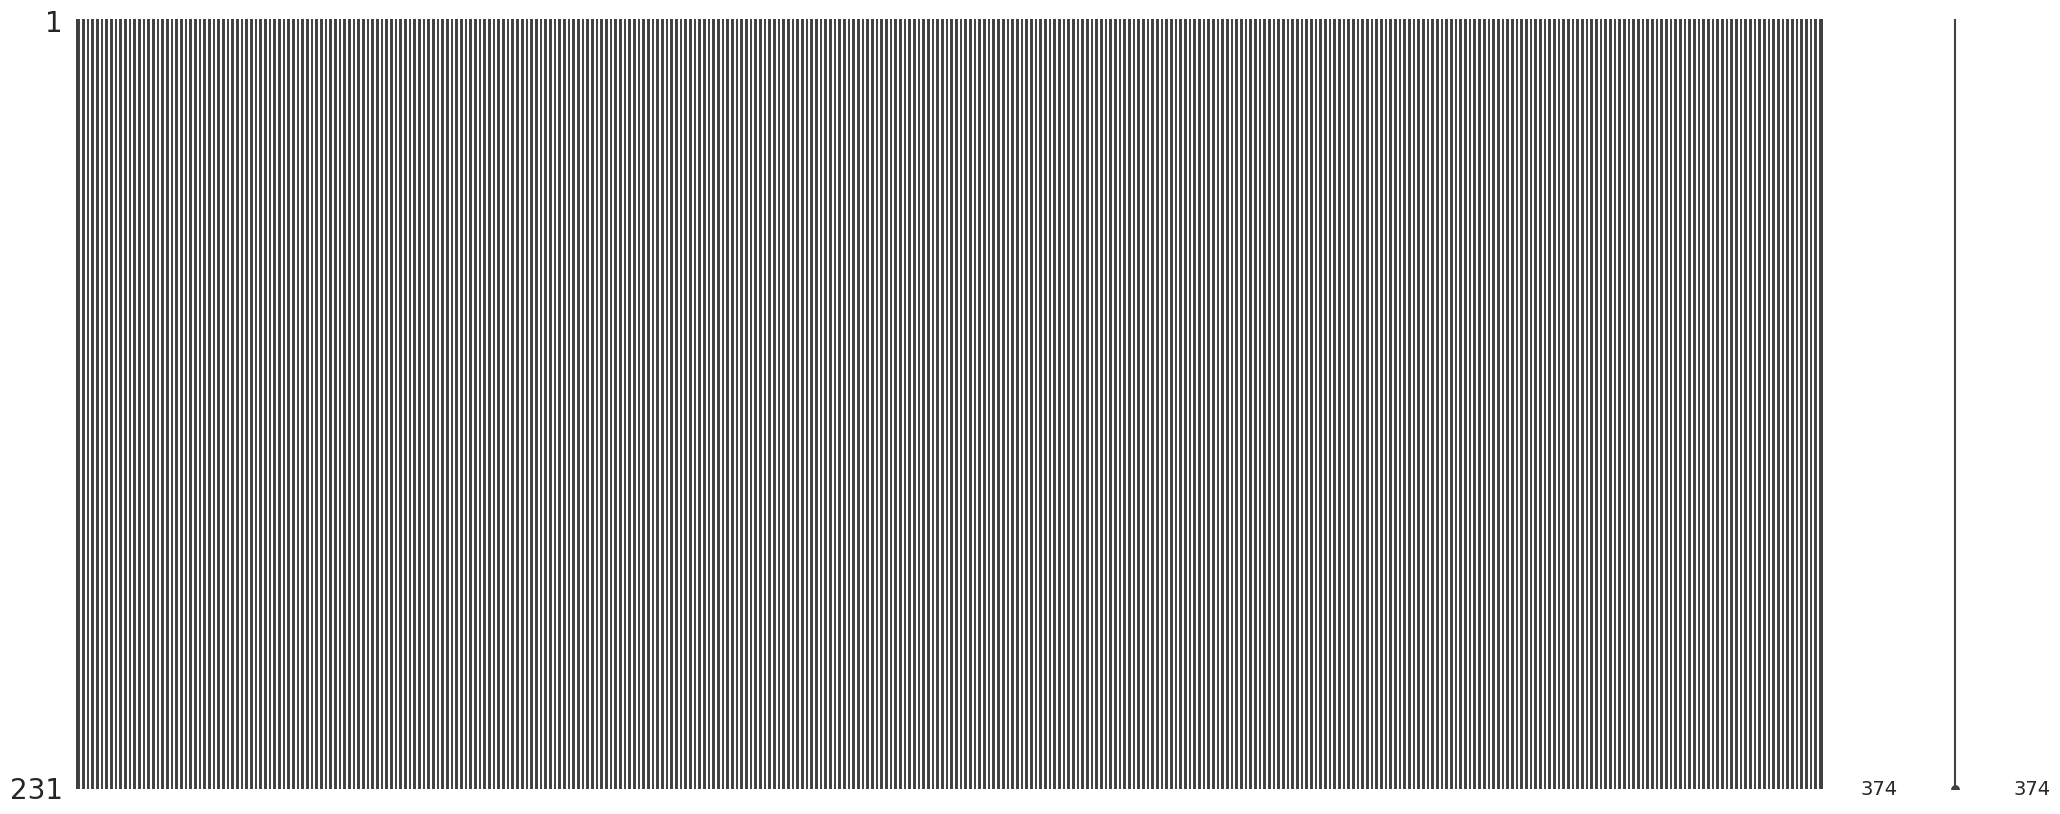

In [31]:
msno.matrix(df_producao_petroleo)

In [32]:
df_producao_petroleo.head()

,Jan 1993,Feb 1993,Mar 1993,Apr 1993,May 1993,Jun 1993,Jul 1993,Aug 1993,Sep 1993,Oct 1993,...,May 2023,Jun 2023,Jul 2023,Aug 2023,Sep 2023,Oct 2023,Nov 2023,Dec 2023,Jan 2024,Continent
Country,,,,,,,,,,,,,,,,,,,,,
World,66906.949,67167.756,66038.889,65740.441,65598.901,65365.926,66008.115,65785.375,66267.798,66932.833,...,100752.614072,102162.240648,101496.235018,101225.103496,102276.987791,102380.943529,103125.152060,103161.099165,100753.292354,World
Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Asia
Albania,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,...,14.166445,14.085455,14.003119,13.922079,13.841348,13.760420,13.681141,13.603075,13.522510,Europe
Algeria,1324.000,1324.000,1314.000,1309.000,1304.000,1304.000,1309.000,1304.000,1299.000,1299.000,...,1451.186260,1421.207112,1431.200188,1411.199364,1421.204899,1431.185751,1431.200640,1421.219929,1391.187605,Africa
American Samoa,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Oceania


In [33]:
df_producao_petroleo.set_index(['Continent'], append=True, inplace=True)
df_producao_petroleo.head()

,,Jan 1993,Feb 1993,Mar 1993,Apr 1993,May 1993,Jun 1993,Jul 1993,Aug 1993,Sep 1993,Oct 1993,...,Apr 2023,May 2023,Jun 2023,Jul 2023,Aug 2023,Sep 2023,Oct 2023,Nov 2023,Dec 2023,Jan 2024
Country,Continent,,,,,,,,,,,,,,,,,,,,,
World,World,66906.949,67167.756,66038.889,65740.441,65598.901,65365.926,66008.115,65785.375,66267.798,66932.833,...,101425.168291,100752.614072,102162.240648,101496.235018,101225.103496,102276.987791,102380.943529,103125.152060,103161.099165,100753.292354
Afghanistan,Asia,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Albania,Europe,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,11.000,...,14.249207,14.166445,14.085455,14.003119,13.922079,13.841348,13.760420,13.681141,13.603075,13.522510
Algeria,Africa,1324.000,1324.000,1314.000,1309.000,1304.000,1304.000,1309.000,1304.000,1299.000,1299.000,...,1481.181337,1451.186260,1421.207112,1431.200188,1411.199364,1421.204899,1431.185751,1431.200640,1421.219929,1391.187605
American Samoa,Oceania,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
df_producao_petroleo_dash = pd.melt(df_producao_petroleo.reset_index(), id_vars=['Country', 'Continent'], var_name='Mês', value_name='Quantidade').sort_values(['Country','Quantidade'], ascending=False)
df_producao_petroleo_dash.head()

,Country,Continent,Mês,Quantidade
63986,Zimbabwe,Africa,Jan 2016,0.819
64217,Zimbabwe,Africa,Feb 2016,0.819
64448,Zimbabwe,Africa,Mar 2016,0.819
64679,Zimbabwe,Africa,Apr 2016,0.819
64910,Zimbabwe,Africa,May 2016,0.819


In [35]:
df_producao_petroleo_dash.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86163 entries, 63986 to 85933
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     86163 non-null  object 
 1   Continent   86163 non-null  object 
 2   Mês         86163 non-null  object 
 3   Quantidade  86163 non-null  float64
dtypes: float64(1), object(3)
memory usage: 5.3+ MB


In [36]:
df_producao_petroleo_dash['Mês'] = pd.to_datetime(df_producao_petroleo_dash['Mês'], format = "%b %Y")

In [37]:
df_producao_petroleo_dash.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86163 entries, 63986 to 85933
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Country     86163 non-null  object        
 1   Continent   86163 non-null  object        
 2   Mês         86163 non-null  datetime64[ns]
 3   Quantidade  86163 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.3+ MB


In [38]:
df_producao_petroleo_dash.head()

,Country,Continent,Mês,Quantidade
63986,Zimbabwe,Africa,2016-01-01,0.819
64217,Zimbabwe,Africa,2016-02-01,0.819
64448,Zimbabwe,Africa,2016-03-01,0.819
64679,Zimbabwe,Africa,2016-04-01,0.819
64910,Zimbabwe,Africa,2016-05-01,0.819


In [39]:
df_producao_petroleo_T = df_producao_petroleo.copy()
df_producao_petroleo_T.reset_index(inplace=True)
df_producao_petroleo_T.drop('Continent', axis = 1, inplace = True)
df_producao_petroleo_T.set_index('Country', inplace=True)
df_producao_petroleo_T = df_producao_petroleo_T.transpose()
df_producao_petroleo_T = df_producao_petroleo_T.reset_index()
df_producao_petroleo_T.rename(columns={"index": "Data"}, inplace = True)
df_producao_petroleo_T.index.names = ['index']

In [40]:
df_producao_petroleo_T.head()

Country,Data,World,Afghanistan,Albania,Algeria,American Samoa,Angola,Antarctica,Antigua and Barbuda,Argentina,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Wake Island,Western Sahara,Yemen,Zambia,Zimbabwe
index,,,,,,,,,,,,,,,,,,,,,
0,Jan 1993,66906.949,0.0,11.0,1324.0,0.0,500.0,0.0,0.0,625.0,...,0.0,70.0,0.0,2528.0,120.0,0.0,0.0,192.0,0.0,0.0
1,Feb 1993,67167.756,0.0,11.0,1324.0,0.0,510.0,0.0,0.0,615.0,...,0.0,70.0,0.0,2538.0,120.0,0.0,0.0,192.0,0.0,0.0
2,Mar 1993,66038.889,0.0,11.0,1314.0,0.0,525.0,0.0,0.0,576.0,...,0.0,70.0,0.0,2428.0,120.0,0.0,0.0,192.0,0.0,0.0
3,Apr 1993,65740.441,0.0,11.0,1309.0,0.0,525.0,0.0,0.0,620.0,...,0.0,75.0,0.0,2428.0,120.0,0.0,0.0,192.0,0.0,0.0
4,May 1993,65598.901,0.0,11.0,1304.0,0.0,520.0,0.0,0.0,638.0,...,0.0,75.0,0.0,2428.0,120.0,0.0,0.0,192.0,0.0,0.0


In [41]:
df_producao_petroleo_T.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Columns: 232 entries, Data to Zimbabwe
dtypes: float64(231), object(1)
memory usage: 676.2+ KB


In [42]:
for col in df_producao_petroleo_T.columns:
    if col != 'Data':
      df_producao_petroleo_T[col] = pd.to_numeric(df_producao_petroleo_T[col])
    else:
      df_producao_petroleo_T[col] = pd.to_datetime(df_producao_petroleo_T[col], format = "%b %Y")

In [43]:
df_producao_petroleo_T.set_index('Data', inplace=True)

In [44]:
df_producao_petroleo_T.head()

Country,World,Afghanistan,Albania,Algeria,American Samoa,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Wake Island,Western Sahara,Yemen,Zambia,Zimbabwe
Data,,,,,,,,,,,,,,,,,,,,,
1993-01-01,66906.949,0.0,11.0,1324.0,0.0,500.0,0.0,0.0,625.0,0.0,...,0.0,70.0,0.0,2528.0,120.0,0.0,0.0,192.0,0.0,0.0
1993-02-01,67167.756,0.0,11.0,1324.0,0.0,510.0,0.0,0.0,615.0,0.0,...,0.0,70.0,0.0,2538.0,120.0,0.0,0.0,192.0,0.0,0.0
1993-03-01,66038.889,0.0,11.0,1314.0,0.0,525.0,0.0,0.0,576.0,0.0,...,0.0,70.0,0.0,2428.0,120.0,0.0,0.0,192.0,0.0,0.0
1993-04-01,65740.441,0.0,11.0,1309.0,0.0,525.0,0.0,0.0,620.0,0.0,...,0.0,75.0,0.0,2428.0,120.0,0.0,0.0,192.0,0.0,0.0
1993-05-01,65598.901,0.0,11.0,1304.0,0.0,520.0,0.0,0.0,638.0,0.0,...,0.0,75.0,0.0,2428.0,120.0,0.0,0.0,192.0,0.0,0.0


# Exportação das Bases para o DASH

In [45]:
df_producao_petroleo_dash.to_csv(outdir_Dash+'/df_producao_petroleo_dash.csv', index=False, decimal='.', sep=';')

In [46]:
df_preco_barril.to_csv(outdir_Dash+'/df_preco_barril.csv', index=False, decimal='.', sep=';')

In [47]:
df_preco_barril.to_csv(outdir_Modelo+'/df_modelo.csv', index=False, decimal='.', sep=';')

In [48]:
df_preco_barril_eventos.to_csv(outdir_Dash+'/df_preco_barril_eventos.csv', index=False, decimal='.', sep=';')

In [49]:
df_dolar_compra.to_csv(outdir_Dash+'/df_dolar_compra.csv', index=False, decimal='.', sep=';')

In [50]:
df_dolar_venda.to_csv(outdir_Dash+'/df_dolar_venda.csv', index=False, decimal='.', sep=';')

In [51]:
df_producao_petroleo.to_csv(outdir_Dash+'/df_producao_petroleo.csv', decimal='.', sep=';')

In [52]:
df_producao_petroleo_T.to_csv(outdir_Dash+'/df_producao_petroleo_T.csv', decimal='.', sep=';')

In [53]:
df_exp_petroleo.to_csv(outdir_Dash+'/df_exp_petroleo.csv', index=False, decimal='.', sep=';')

In [54]:
df_imp_petroleo.to_csv(outdir_Dash+'/df_imp_petroleo.csv', index=False, decimal='.', sep=';')

In [55]:
df_anp_petroleo.to_csv(outdir_Dash+'/df_anp_petroleo.csv', index=False, decimal='.', sep=';')

# Criação Modelo

## Análise sobre modelos

In [56]:
df_ML = df_preco_barril.copy()

In [57]:
df_ML = df_ML.rename(columns= {'Data':'ds', 'Preco': 'y'})
df_ML.set_index('ds', inplace=True )

In [58]:
df_ML.head()

,y
ds,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-23,18.55
1987-05-24,18.55


In [59]:
ma_df = df_ML.rolling(12).mean()
std_df = df_ML.rolling(12).std()

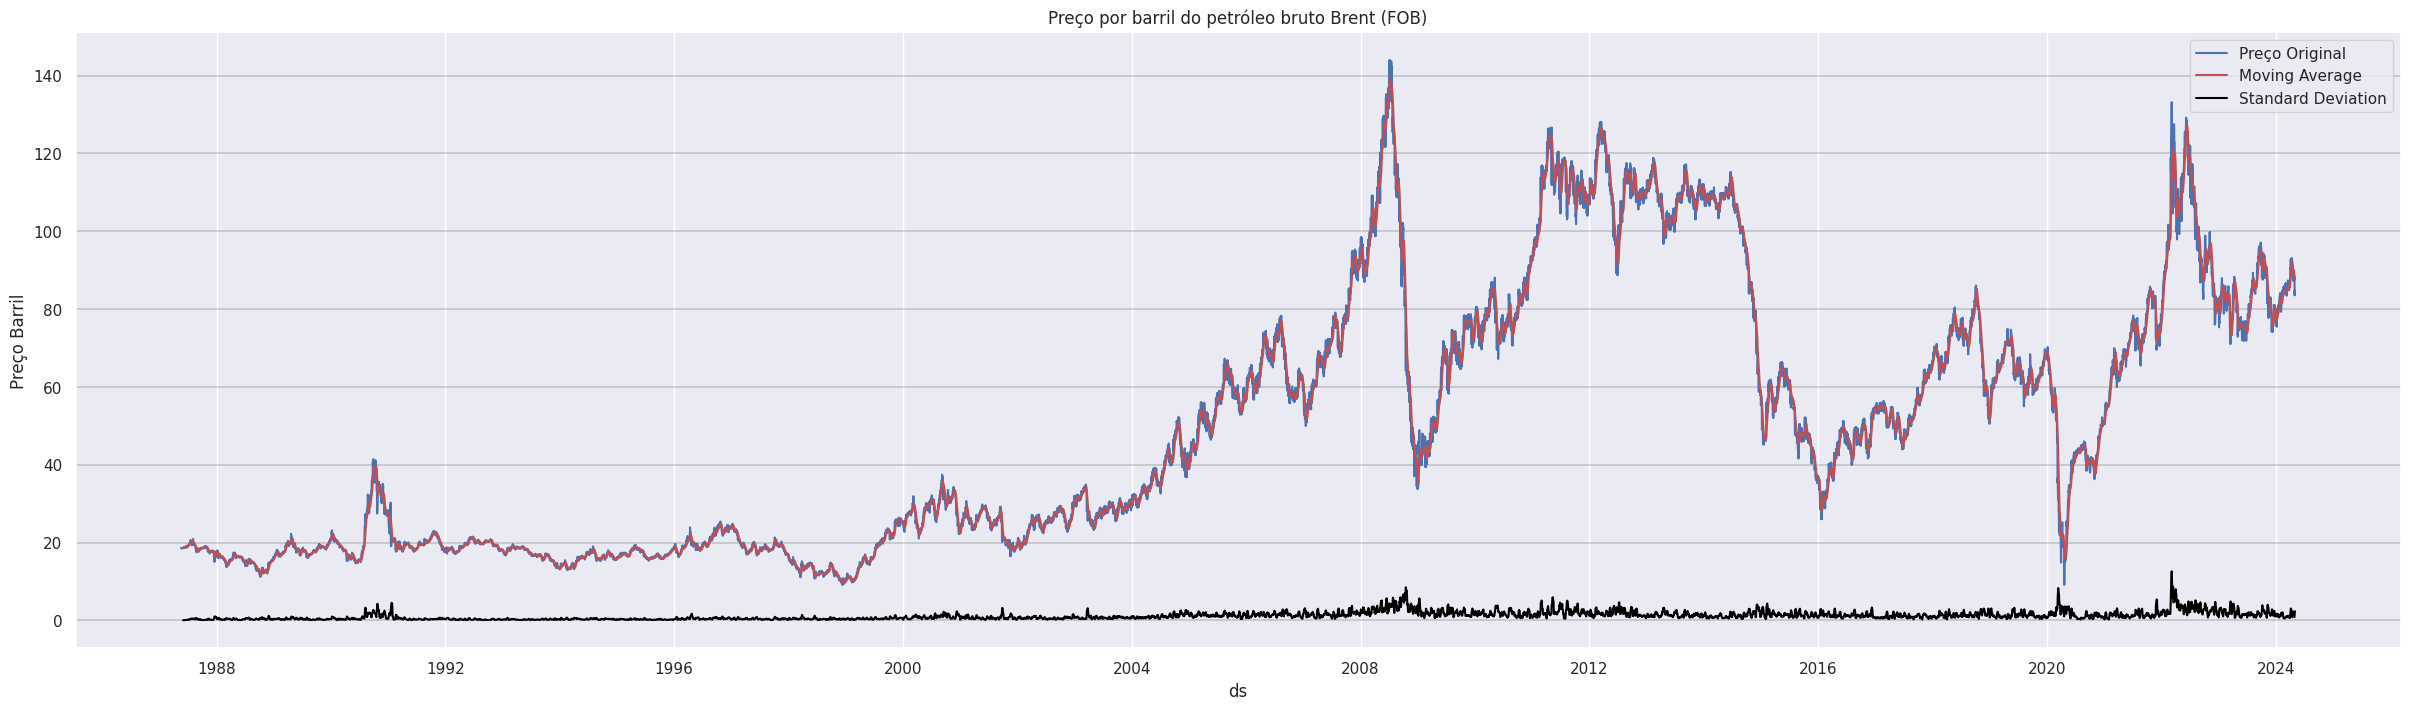

In [60]:
plot_SerieTemporal(df_ML, 'Preço por barril do petróleo bruto Brent (FOB)', ma_df, std_df)

### Preparação da Série Temporal

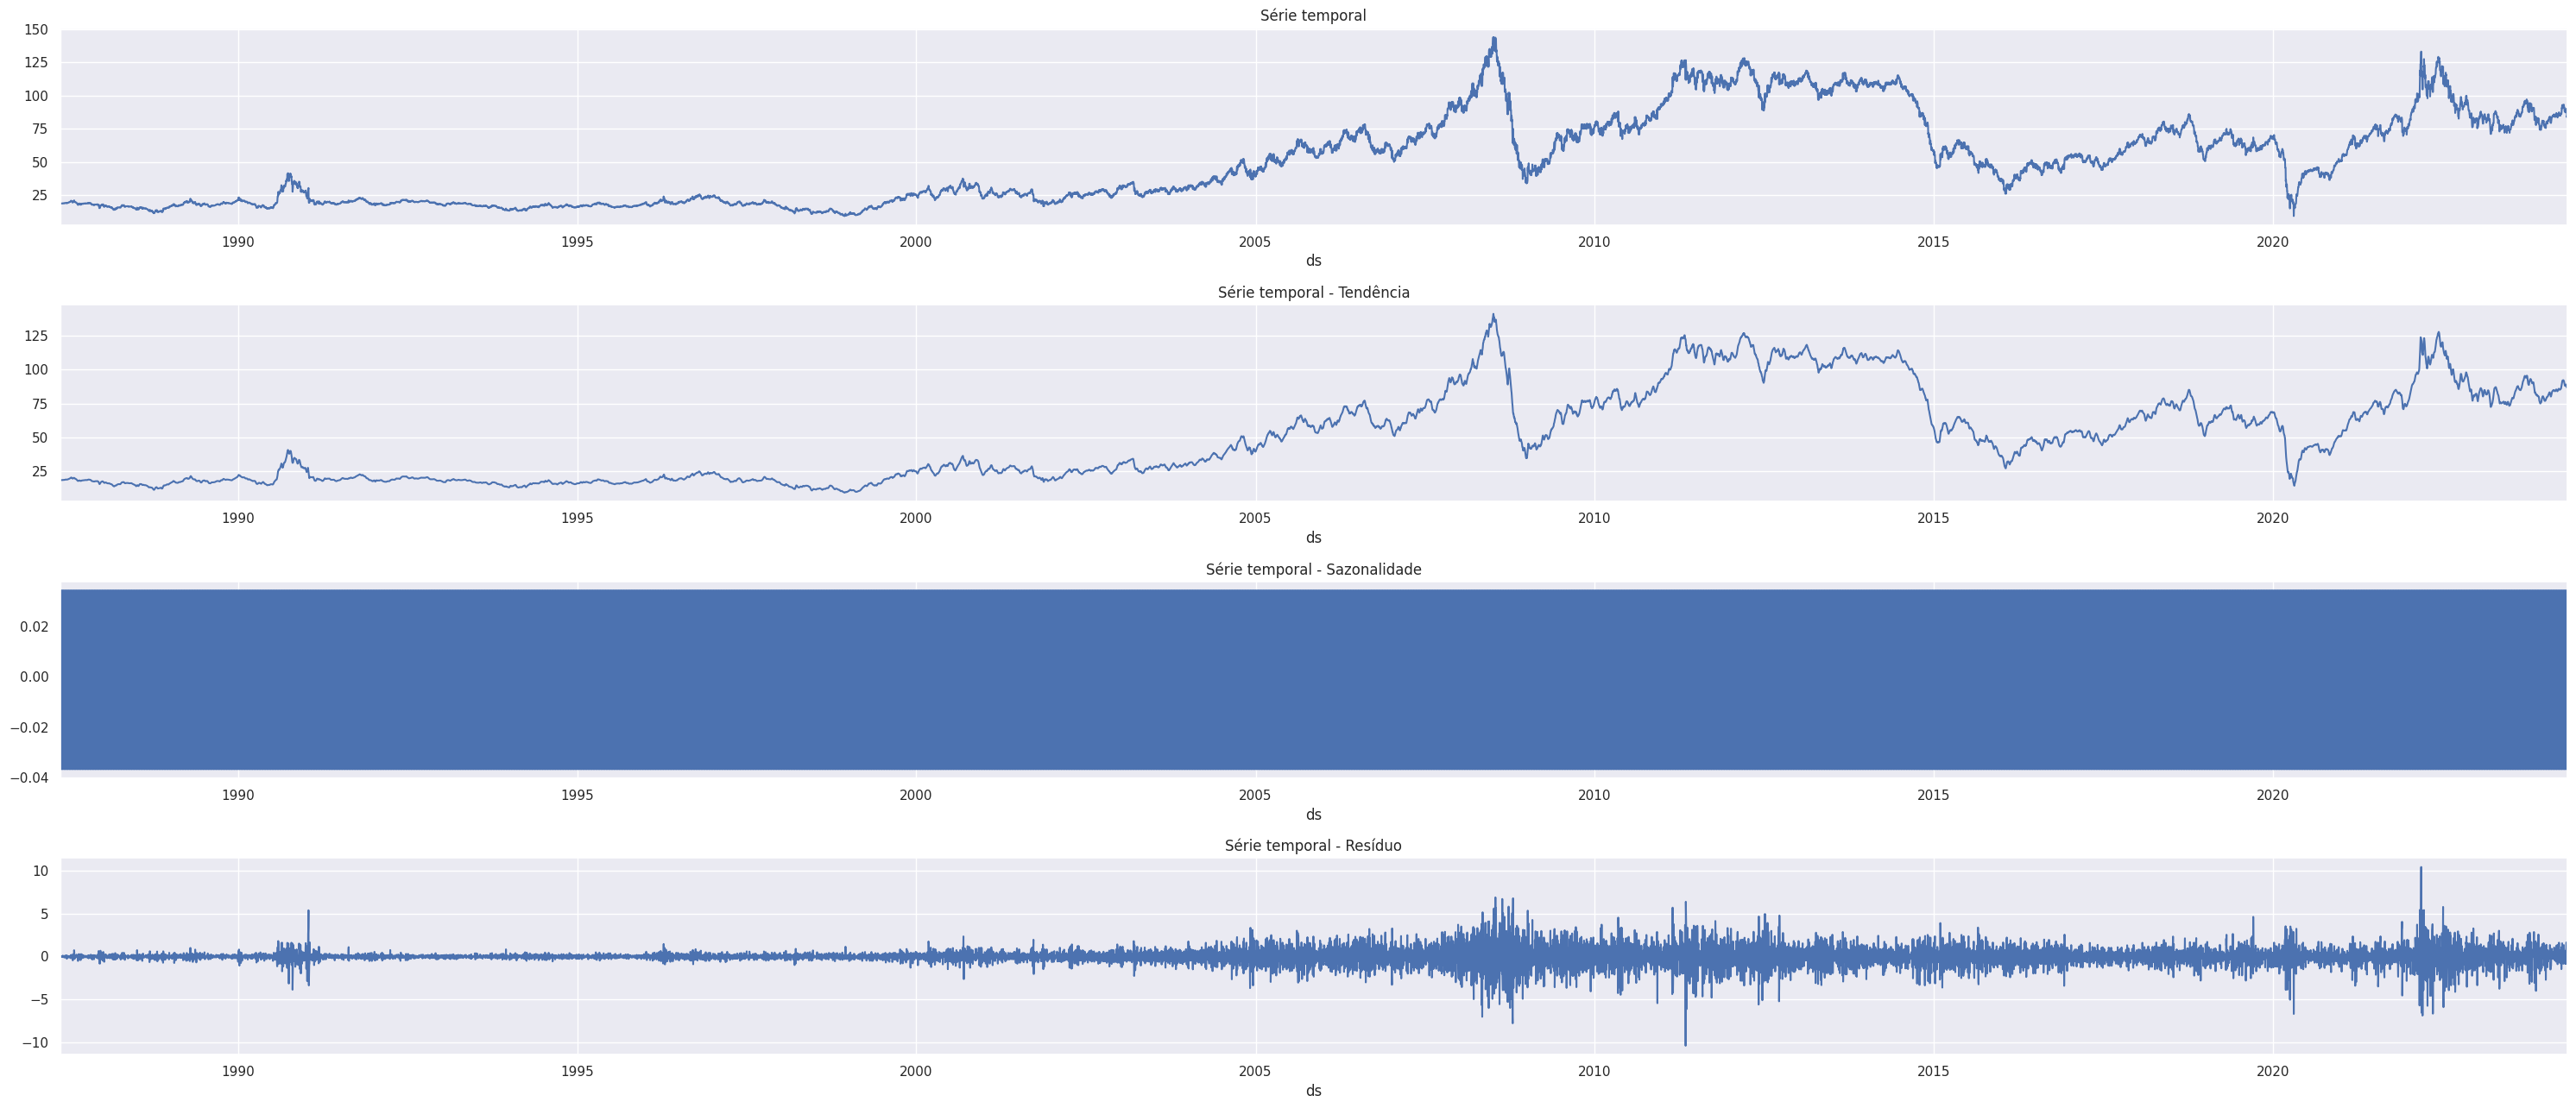

In [61]:
plot_sazonalidade(df_ML)

In [62]:
teste_ADF(df_ML.y)

Teste ADF
H0 = hipótese nula (não é estacionária)
H1 = hipótese alternativa (é estacionária)
Teste estatístico: -2.0507094327449216
P-value: 0.2647905399298647


Valores críticos:
1%: -3.4308360331291654
5%: -2.8617548038086422
10%: -2.5668843351964736


**Resultado:** Base não estacionária, pois o p-value está acima do esperado (0.26) e o teste estatístico (-2.050) é maior do que todos os valores críticos

In [63]:
## Transformação Logaritmica
df_log = np.log(df_ML)
ma_df_log = df_log.rolling(12).mean()
std_df_log = df_log.rolling(12).std()

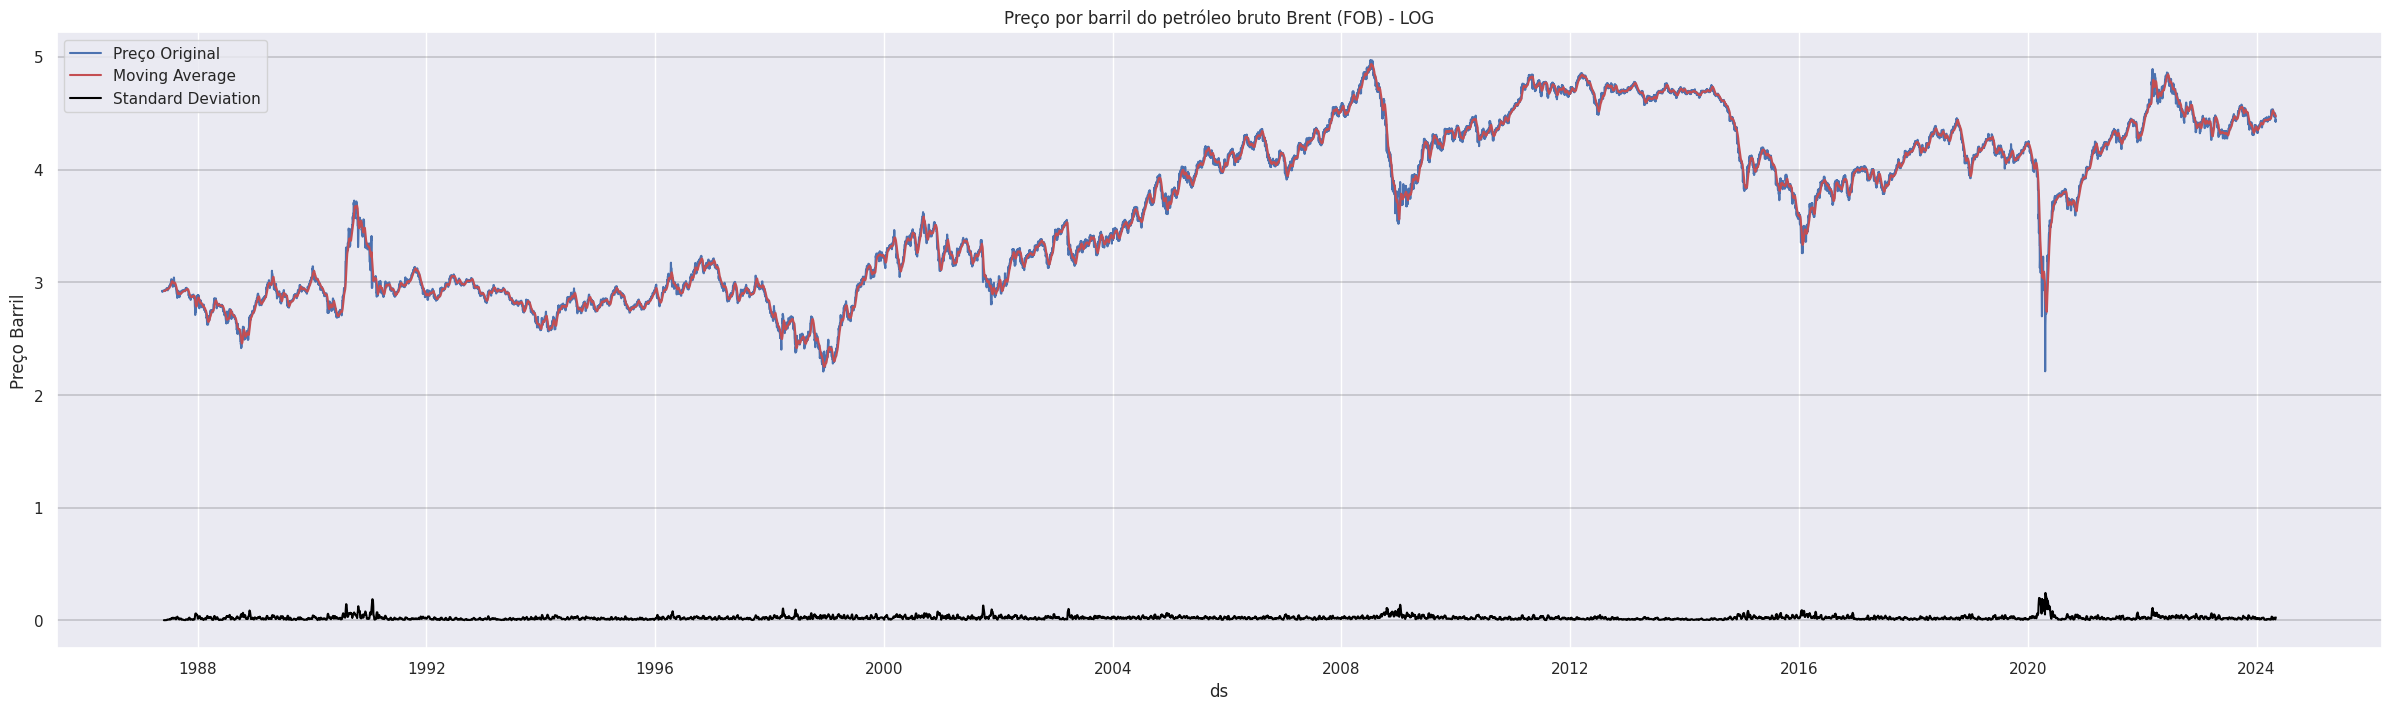

In [64]:
plot_SerieTemporal(df_log, 'Preço por barril do petróleo bruto Brent (FOB) - LOG', ma_df_log, std_df_log)

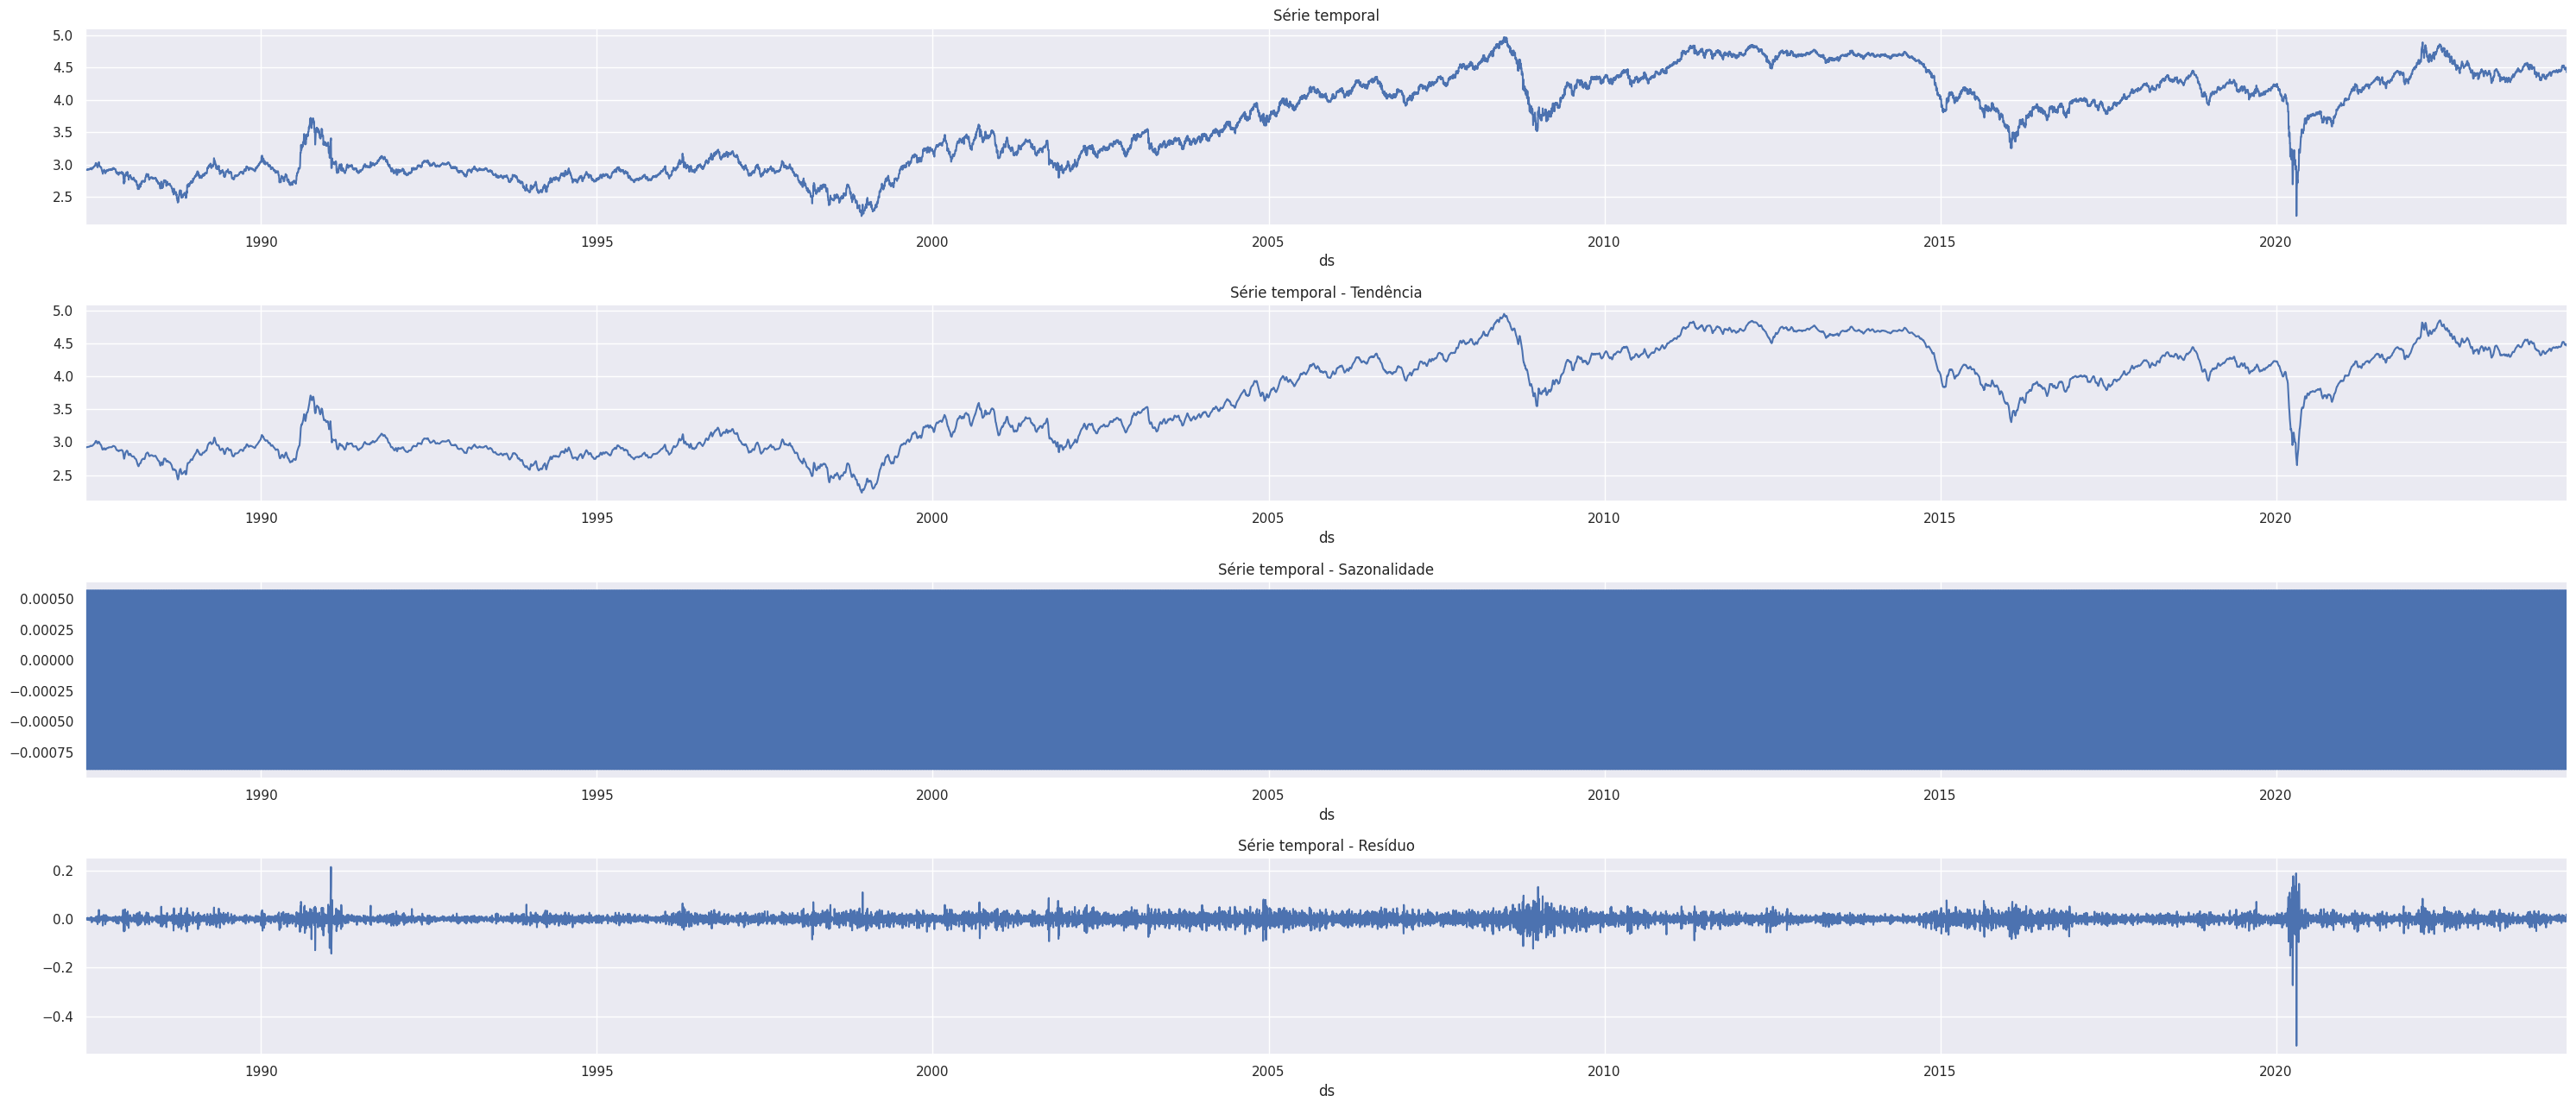

In [65]:
plot_sazonalidade(df_log)

In [66]:
teste_ADF(df_log.y)

Teste ADF
H0 = hipótese nula (não é estacionária)
H1 = hipótese alternativa (é estacionária)
Teste estatístico: -1.865331846285565
P-value: 0.34854165575388174


Valores críticos:
1%: -3.4308358886745602
5%: -2.8617547399717163
10%: -2.5668843012166196


**Resultado:** Base não estacionária, pois o p-value está acima do esperado (0.34) e o teste estatístico (-1.865) é maior do que todos os valores críticos

In [67]:
## Série Temporal Derivada
dados_diff = df_log.diff(1)
ma_diff = dados_diff.rolling(12).mean()
std_diff = dados_diff.rolling(12).std()
dados_diff.dropna(inplace=True)

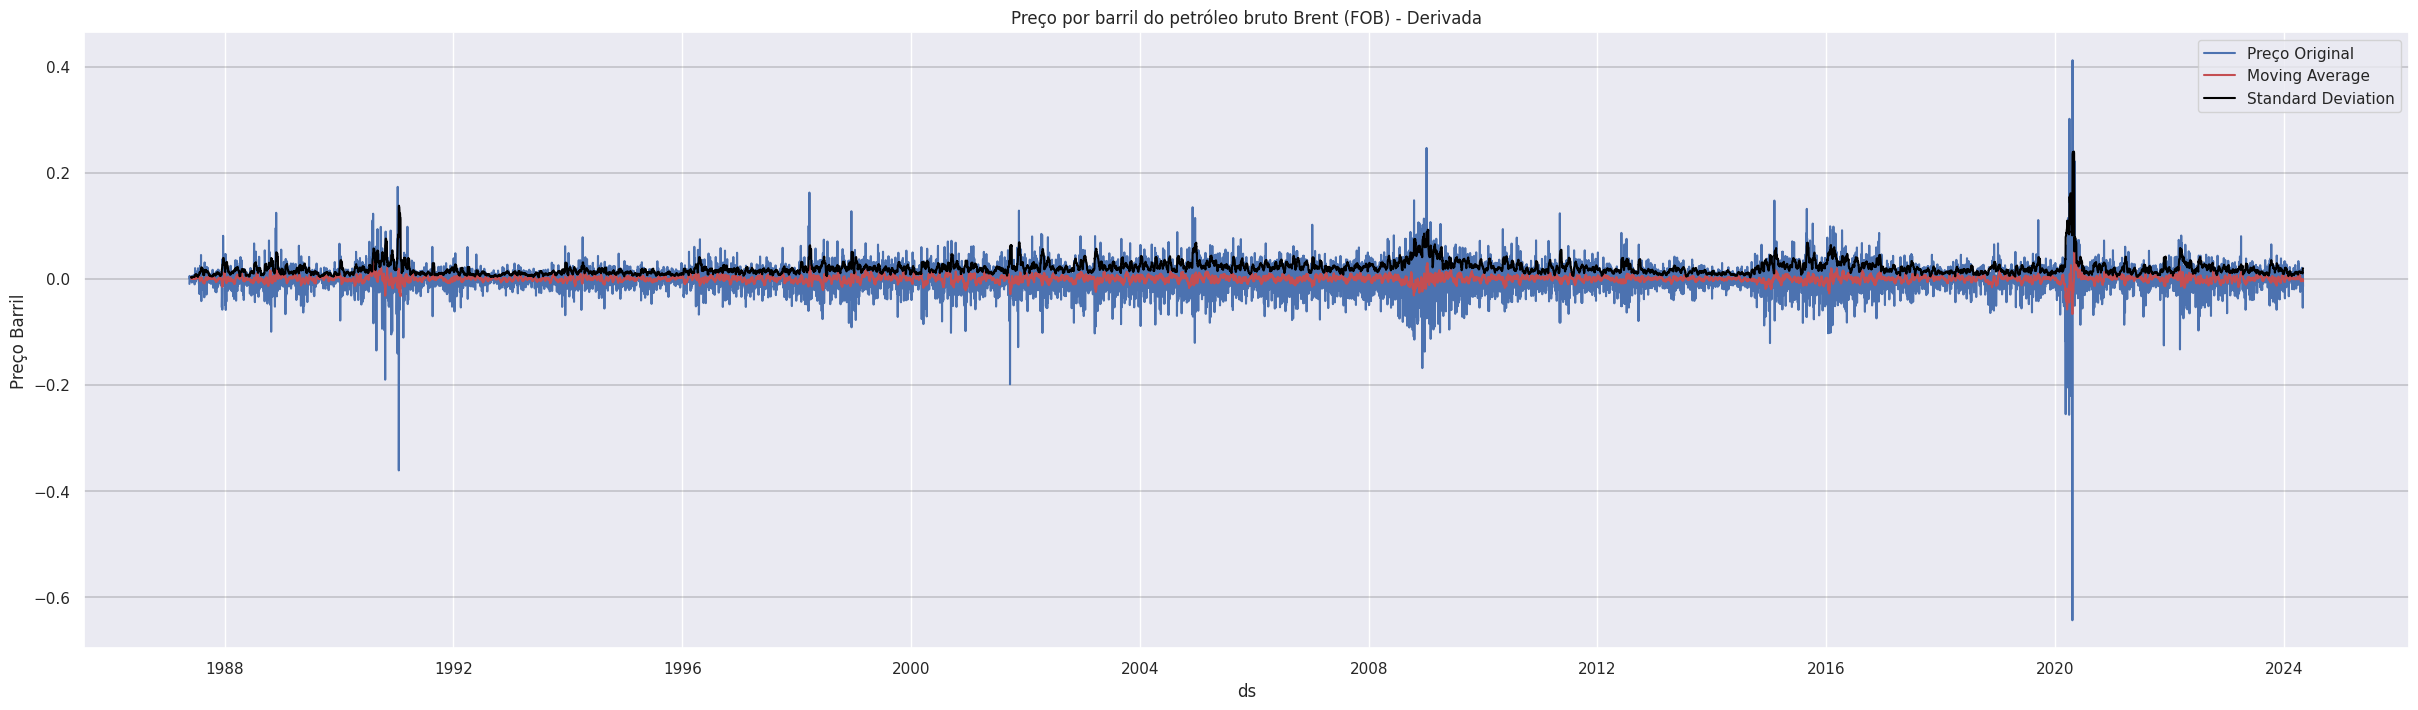

In [68]:
plot_SerieTemporal(dados_diff, 'Preço por barril do petróleo bruto Brent (FOB) - Derivada', ma_diff, std_diff)

In [69]:
teste_ADF(dados_diff.y)

Teste ADF
H0 = hipótese nula (não é estacionária)
H1 = hipótese alternativa (é estacionária)
Teste estatístico: -17.853386886794485
P-value: 3.0732261717307076e-30


Valores críticos:
1%: -3.4308358886745602
5%: -2.8617547399717163
10%: -2.5668843012166196


**Resultado:** Base estacionária, pois o p-value está abixo do esperado (0) e o teste estatístico (-17.853) é menor do que todos os valores críticos

### SEPARANDO BASE DE TESTE E TREINO

In [70]:
df_modelo = df_ML[df_ML.index >= pd.Timestamp('2004-01-01')]

In [71]:
df_modelo = df_modelo.reset_index()

In [72]:
df_modelo.to_csv(outdir_Modelo+'/df_modelo_10.csv', index=False, decimal='.', sep=';')

In [73]:
df_modelo.shape

(7429, 2)

In [74]:
train_data, test_data = train_test_split(df_modelo, test_size=0.2, shuffle=False)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (5943, 2)
testing data size : (1486, 2)


In [75]:
# Criação da base para os modelos do tipo NAIVE e ARIMA (Seperar o ultimo ano para teste)
df_temporal = df_modelo.copy()
df_temporal['unique_id'] = 'FOB'

train_data_temporal = df_temporal.loc[df_temporal.ds < '2023-01-01']
test_data_temporal = df_temporal.loc[df_temporal.ds >= '2023-01-01']
print(f'training data size : {train_data_temporal.shape}')
print(f'testing data size : {test_data_temporal.shape}')

training data size : (6940, 3)
testing data size : (489, 3)


### PROPHET

In [76]:
modelo_Prophet = Prophet(daily_seasonality=True)
modelo_Prophet.fit(train_data)
h = test_data.index.nunique()
dataFramefuture = modelo_Prophet.make_future_dataframe(periods=h, freq='D')
previsao = modelo_Prophet.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmphbsp92h_/co4lnxnv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbsp92h_/9of7px3m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56007', 'data', 'file=/tmp/tmphbsp92h_/co4lnxnv.json', 'init=/tmp/tmphbsp92h_/9of7px3m.json', 'output', 'file=/tmp/tmphbsp92h_/prophet_modeldckka7lj/prophet_model-20240519124915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:49:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:49:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-01-01,29.875239,15.184905,36.964408,29.875239,29.875239,-3.714253,-3.714253,-3.714253,0.488128,...,0.077172,0.077172,0.077172,-4.279553,-4.279553,-4.279553,0.0,0.0,0.0,26.160986
1,2004-01-02,29.919443,14.367960,37.419637,29.919443,29.919443,-3.751398,-3.751398,-3.751398,0.488128,...,0.008515,0.008515,0.008515,-4.248042,-4.248042,-4.248042,0.0,0.0,0.0,26.168044
2,2004-01-03,29.963646,15.176007,38.024800,29.963646,29.963646,-3.781245,-3.781245,-3.781245,0.488128,...,-0.053512,-0.053512,-0.053512,-4.215861,-4.215861,-4.215861,0.0,0.0,0.0,26.182402
3,2004-01-04,30.007850,14.905630,36.972224,30.007850,30.007850,-3.731607,-3.731607,-3.731607,0.488128,...,-0.035944,-0.035944,-0.035944,-4.183791,-4.183791,-4.183791,0.0,0.0,0.0,26.276243
4,2004-01-05,30.052054,14.500117,36.979284,30.052054,30.052054,-3.606681,-3.606681,-3.606681,0.488128,...,0.057812,0.057812,0.057812,-4.152621,-4.152621,-4.152621,0.0,0.0,0.0,26.445373


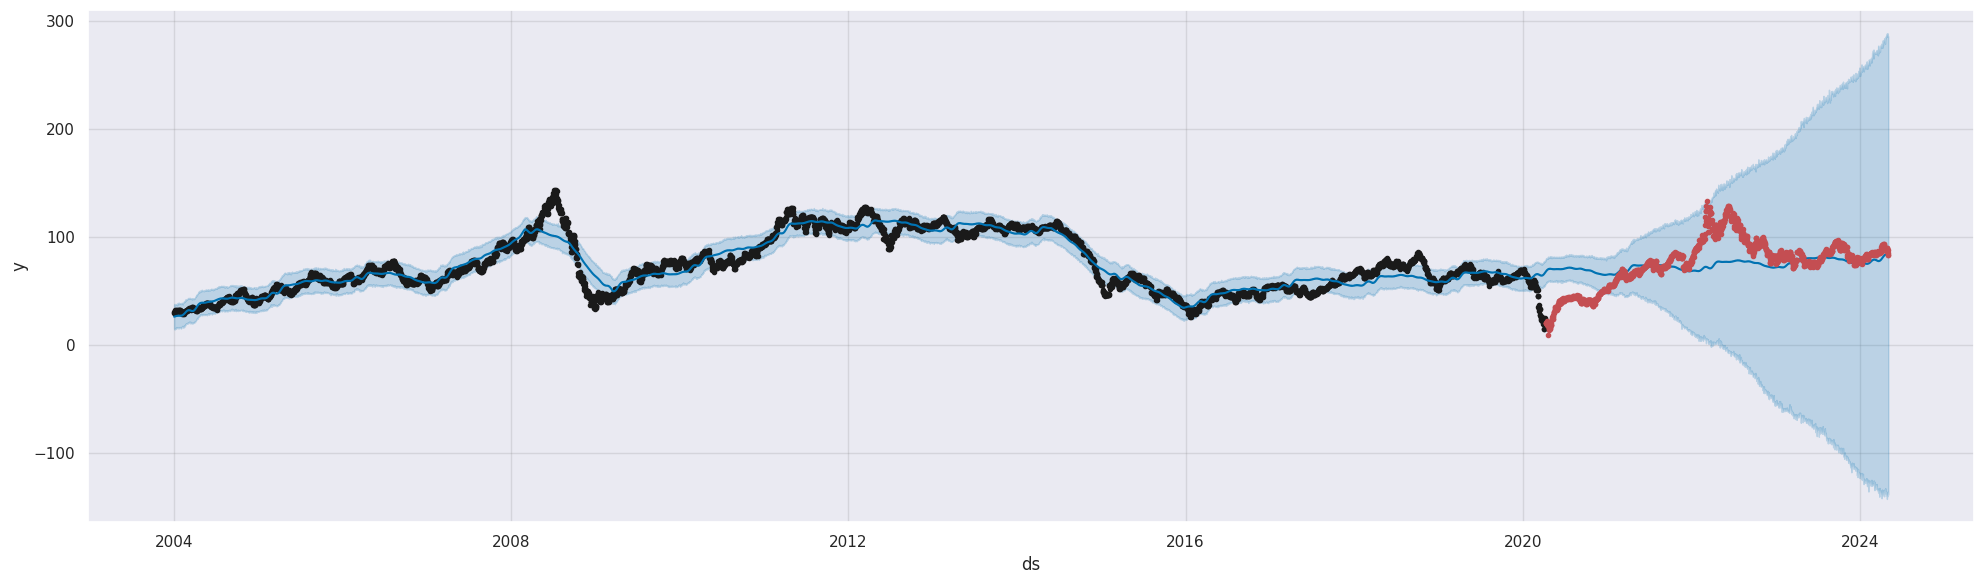

In [77]:
modelo_Prophet.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

In [78]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y'])

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])
wmape = calc_wmape(resultados.y.values, resultados.yhat.values)


print(f"MAPE: {mape:.2f}")
print(f"WMAPE: {wmape:.2f}")

MAPE: 0.10
WMAPE: 0.09


In [79]:
df_modelos.loc['PROPHET'] = {'MAPE':mape, 'WMAPE':wmape, 'Accur':(1-mape)}

### Modelos NAIVE

In [80]:
model = StatsForecast(models=[Naive(),
                            SeasonalNaive(season_length=7),
                            WindowAverage(window_size=7),
                            SeasonalWindowAverage(window_size=3, season_length=7),
                            AutoARIMA(season_length = 60)
                            ],
                            freq='D', n_jobs=-1)


model.fit(train_data_temporal)

StatsForecast(models=[Naive,SeasonalNaive,WindowAverage,SeasWA,AutoARIMA])

In [81]:
forecast_df = model.predict(h=h+1, level=[90])

In [82]:
forecast_df = forecast_df.reset_index().merge(test_data_temporal, on=['ds','unique_id'], how='left')
forecast_df.dropna(inplace=True)
forecast_df.reset_index(drop=True)

forecast_df.head()

,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,WindowAverage,SeasWA,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,y
0,FOB,2023-01-01,82.82,79.932533,85.707466,82.449997,-2.450552,167.35054,82.23571,79.673332,82.367226,79.607941,85.126503,82.82
1,FOB,2023-01-02,82.82,78.736504,86.903496,82.449997,-2.450552,167.35054,82.23571,80.703331,82.195923,78.642189,85.749649,82.82
2,FOB,2023-01-03,82.82,77.818756,87.821243,82.449997,-2.450552,167.35054,82.23571,80.680000,82.431450,78.481010,86.381897,80.36
3,FOB,2023-01-04,82.82,77.045067,88.594933,81.699997,-3.200552,166.60054,82.23571,81.759995,82.453888,78.126060,86.781715,75.31
4,FOB,2023-01-05,82.82,76.363426,89.276573,80.959999,-3.940550,165.86055,82.23571,80.959999,82.453888,77.594864,87.312920,76.73


Naive WMAPE: 5.69%
Naive Test RMSE: 5.78
Naive MAE: 4.73
Naive MAPE: 0.06


SeasonalNaive WMAPE: 5.78%
SeasonalNaive Test RMSE: 5.85
SeasonalNaive MAE: 4.80
SeasonalNaive MAPE: 0.06


WindowAverage WMAPE: 5.76%
WindowAverage Test RMSE: 5.83
WindowAverage MAE: 4.79
WindowAverage MAPE: 0.06


SeasWA WMAPE: 6.08%
SeasWA Test RMSE: 6.16
SeasWA MAE: 5.05
SeasWA MAPE: 0.06


AutoARIMA WMAPE: 5.73%
AutoARIMA Test RMSE: 5.81
AutoARIMA MAE: 4.76
AutoARIMA MAPE: 0.06




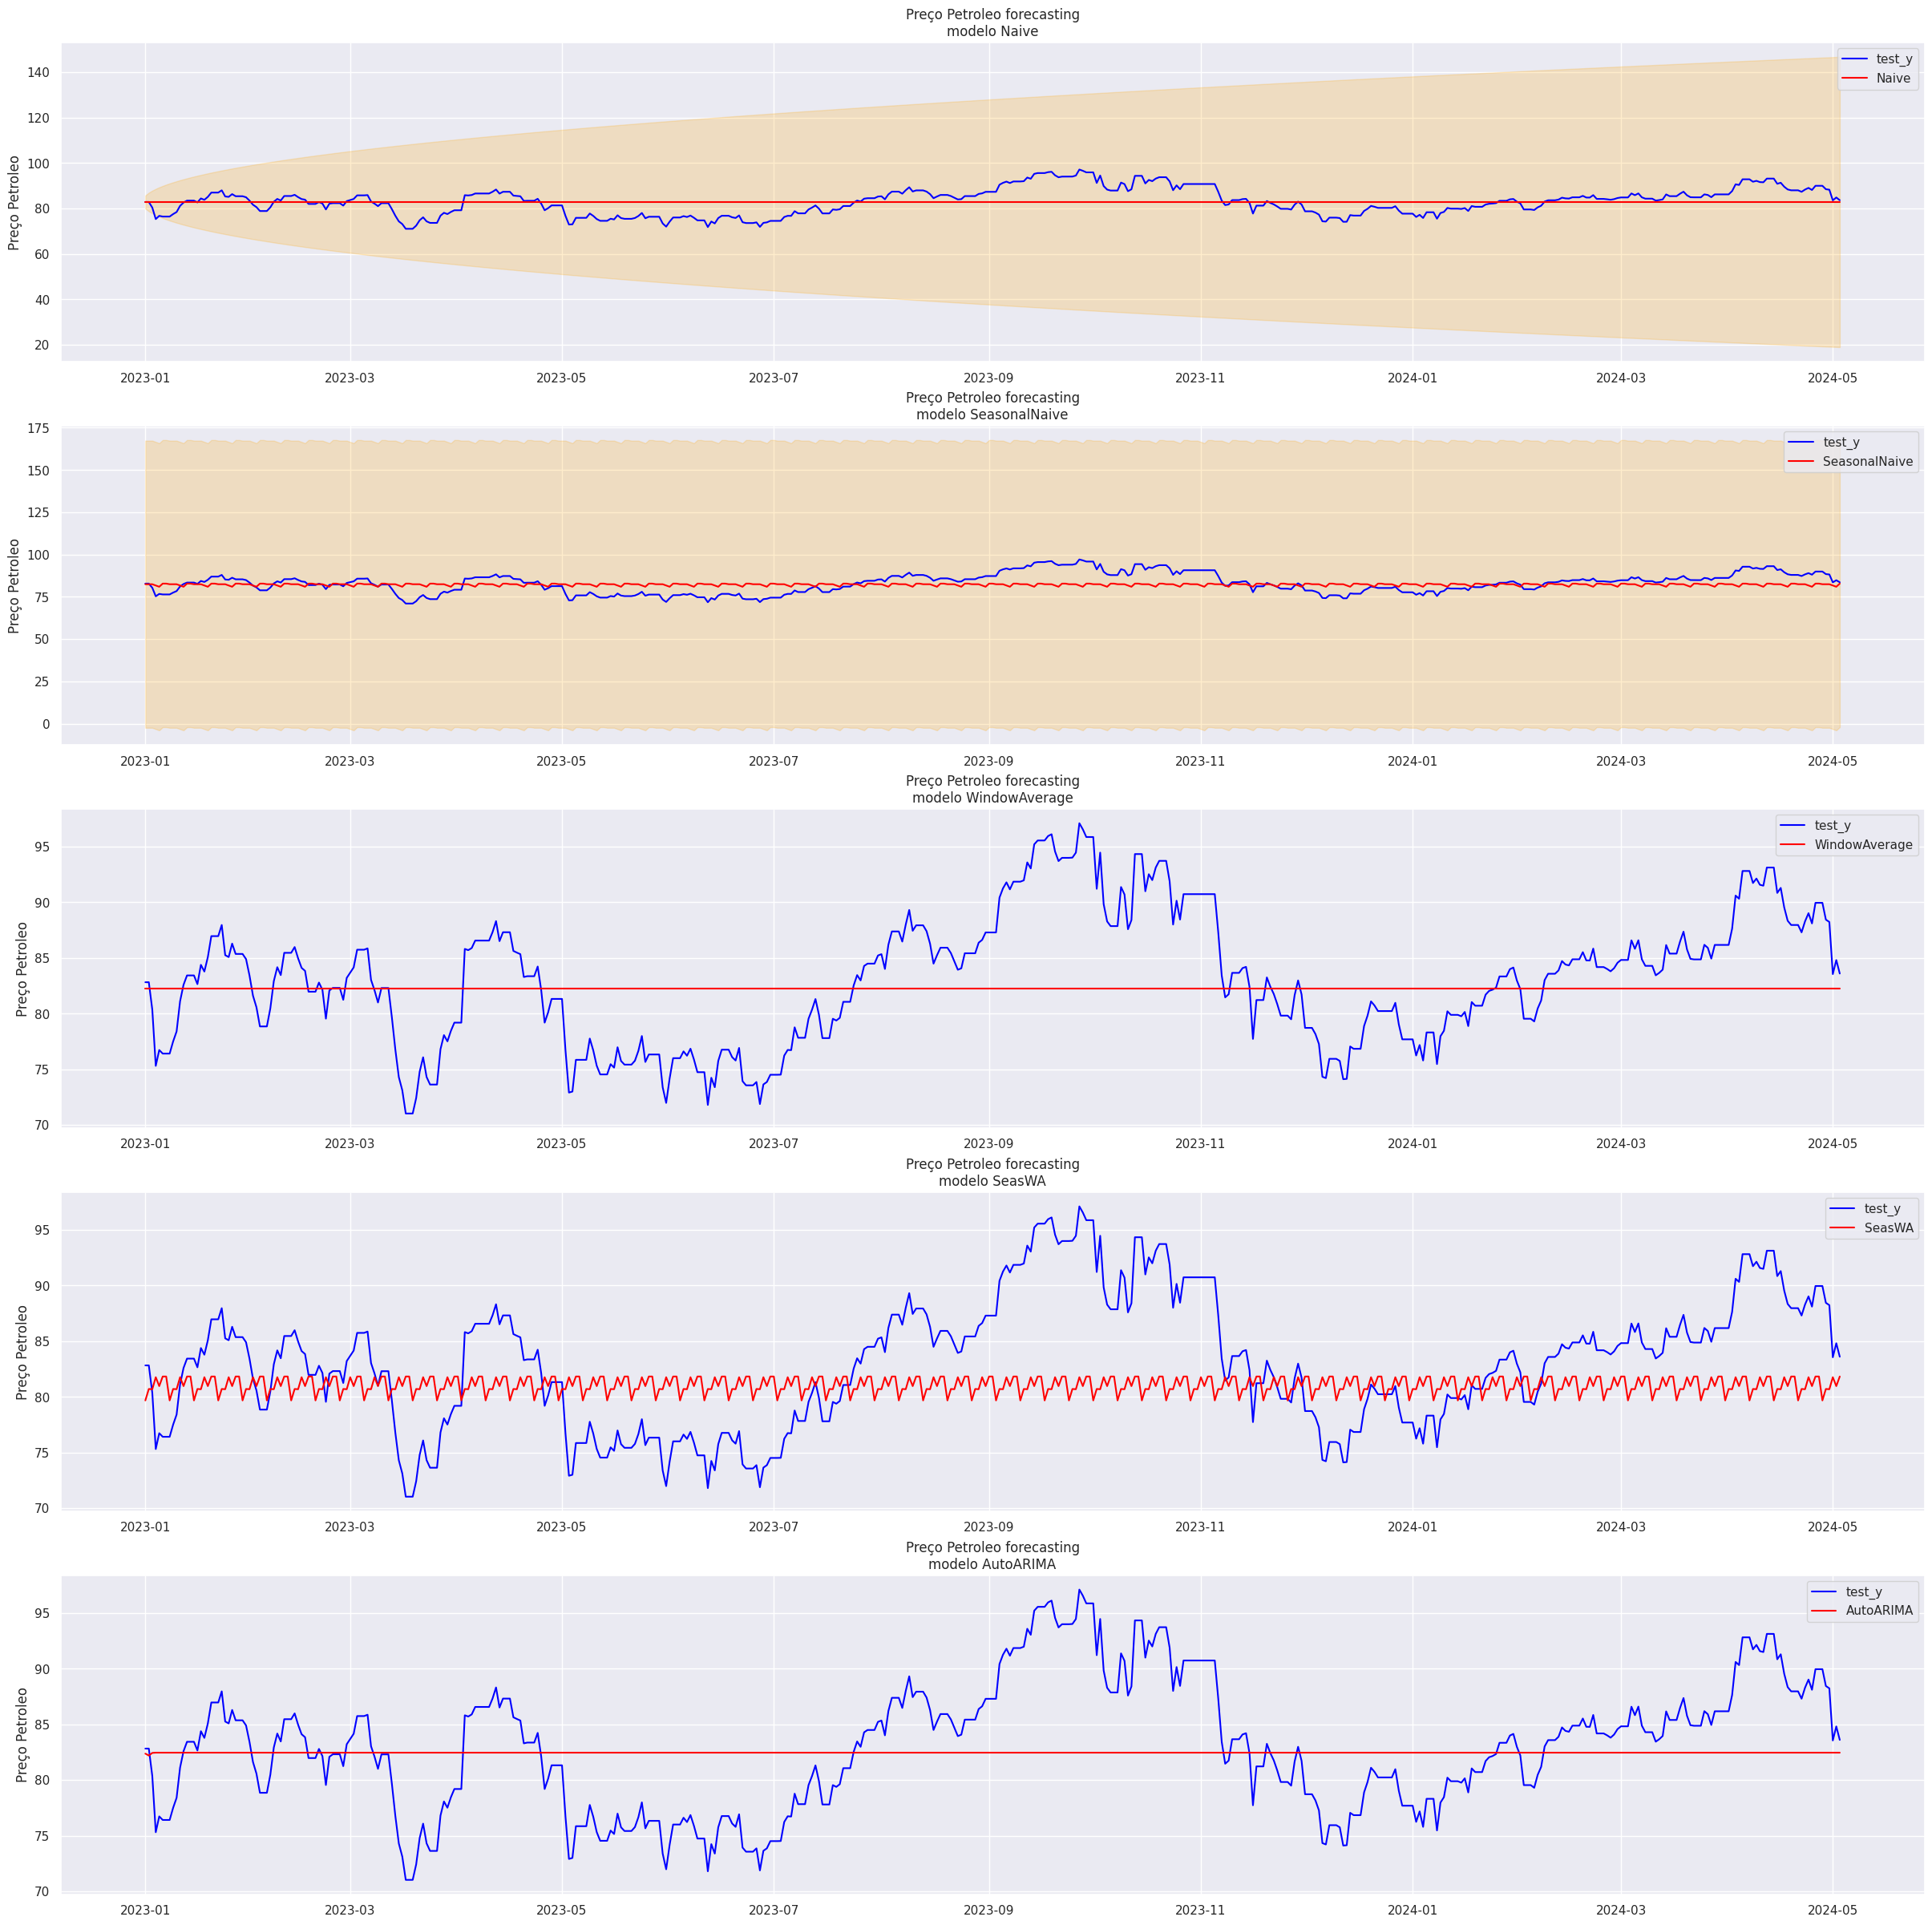

In [83]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(30, 30))

list_models = ['Naive', 'SeasonalNaive', 'WindowAverage', 'SeasWA','AutoARIMA']

for model_ in list_models:
    i = list_models.index(model_)

    sns.lineplot(forecast_df, x='ds', y='y', ax=ax[i], color='blue', label='test_y')
    sns.lineplot(forecast_df, x='ds', y=model_, ax=ax[i], color='red', label=model_)

    ax[i].set_xlabel('')
    ax[i].set_ylabel('Preço Petroleo')

    ax[i].set_title(f'Preço Petroleo forecasting\nmodelo {model_}')

    if model_ in ['Naive', 'SeasonalNaive']:
        ax[i].fill_between(forecast_df.ds.values, forecast_df[f'{model_}-lo-90'], forecast_df[f'{model_}-hi-90'], alpha=0.2, color='orange')

    wmape_ = calc_wmape(forecast_df.y.values, forecast_df[f'{model_}'].values)
    rmse_ = sqrt(mean_squared_error(forecast_df.y.values, forecast_df[f'{model_}'].values))
    mae_ = calc_mae(forecast_df.y.values, forecast_df[f'{model_}'].values)
    mape_ = mean_absolute_percentage_error(forecast_df.y.values, forecast_df[f'{model_}'].values)

    print(f'{model_} WMAPE: {wmape_:.2%}')
    print(f'{model_} Test RMSE: %.2f' % rmse_)
    print(f'{model_} MAE: %.2f' % mae_)
    print(f'{model_} MAPE: %.2f' % mape_)
    print('\n')

    df_modelos.loc[model_] = {'MAPE':mape_, 'WMAPE':wmape_, 'Accur':(1-mape_)}

### Modelo ARIMA

In [84]:
train_data_temporal = train_data_temporal.drop(columns=['unique_id'])
test_data_temporal = test_data_temporal.drop(columns=['unique_id'])

In [85]:
train_data_temporal = train_data_temporal.set_index('ds')
test_data_temporal = test_data_temporal.set_index('ds')

In [86]:
arima_model = ARIMA(train_data_temporal, order=(5,1,0))

In [87]:
arima_model_fit = arima_model.fit()

In [88]:
y_pred = arima_model_fit.forecast(len(test_data_temporal))

In [89]:
residuals = pd.DataFrame(arima_model_fit.resid)

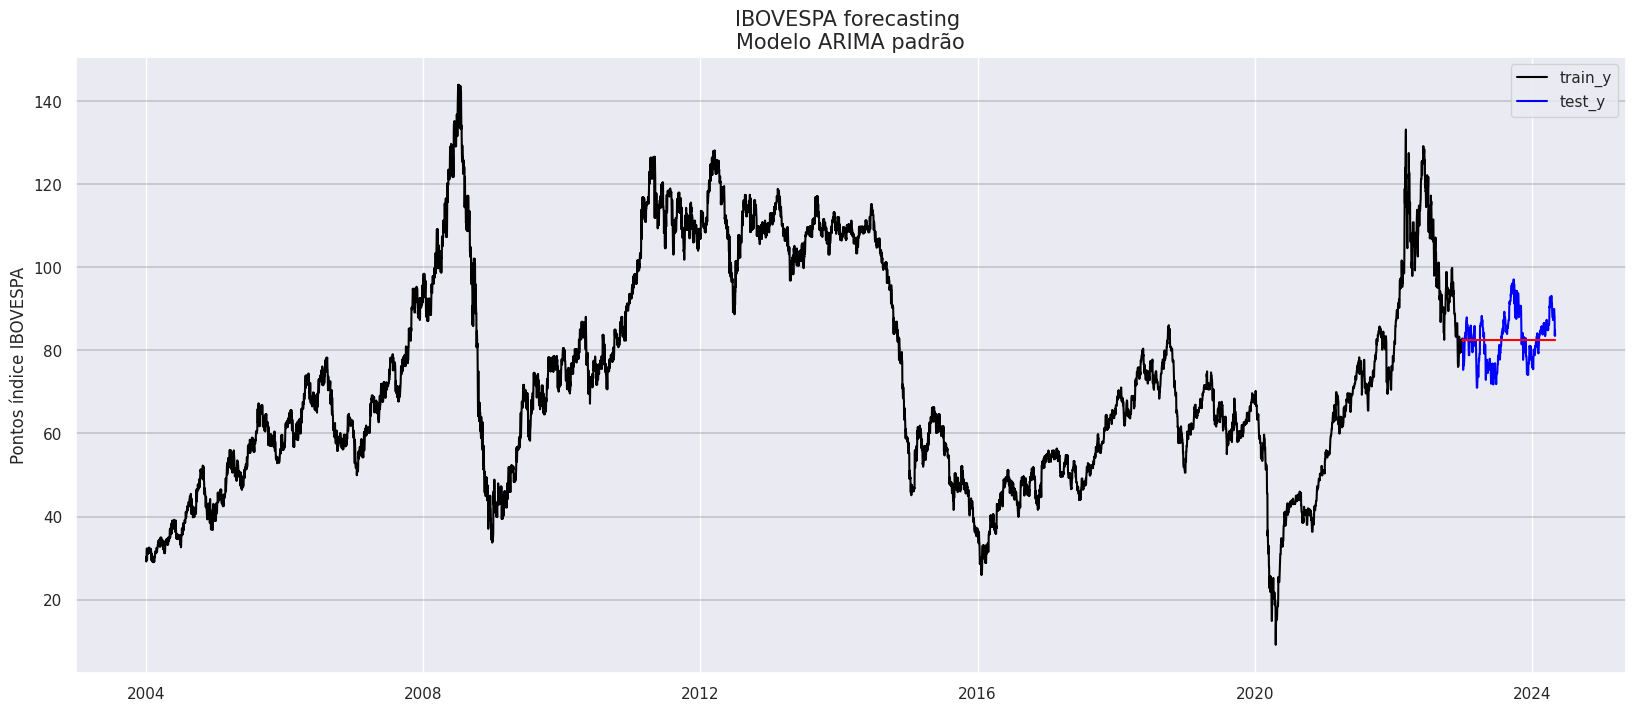

ARIMA padrão WMAPE: 5.73%
ARIMA padrão Test RMSE: 5.80
ARIMA padrão MAE: 4.76
ARIMA padrão MAPE: 0.06


In [90]:
model_ = 'ARIMA padrão'

fig, ax = plt.subplots(figsize=(20,8))

sns.lineplot(train_data_temporal, x='ds', y='y', ax=ax, label='train_y', color='black')
sns.lineplot(test_data_temporal, x='ds', y='y', ax=ax, color='blue', label='test_y')
sns.lineplot(y_pred, ax=ax, color='red')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('IBOVESPA forecasting \nModelo ARIMA padrão', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

wmape_ = calc_wmape(test_data_temporal.y.values, y_pred.values)
rmse_ = sqrt(mean_squared_error(test_data_temporal.y.values, y_pred.values))
mae_ = calc_mae(test_data_temporal.y.values, y_pred.values)
mape_ = mean_absolute_percentage_error(test_data_temporal.y.values, y_pred.values)

print(f'{model_} WMAPE: {wmape_:.2%}')
print(f'{model_} Test RMSE: %.2f' % rmse_)
print(f'{model_} MAE: %.2f' % mae_)
print(f'{model_} MAPE: %.2f' % mape_)

df_modelos.loc[model_] = {'MAPE':mape_, 'WMAPE':wmape_, 'Accur':(1-mape_)}

In [91]:
#Modelo ARIMA "retroalimentado"
y_pred_step = []
history = train_data_temporal.copy()

for i in range(len(test_data_temporal)):
    model_arima_retro = ARIMA(history, order=(5,1,0))
    model_arima_retro_fit = model_arima_retro.fit()

    output = model_arima_retro_fit.forecast(disp=0)
    yhat = output[0]
    y_pred_step.append(yhat)

    obs = test_data_temporal.values[i]

    history = pd.concat([history, pd.DataFrame({'y':obs}, index=[test_data_temporal.index[i]])])

y_pred = test_data_temporal.copy()
y_pred.y = y_pred_step

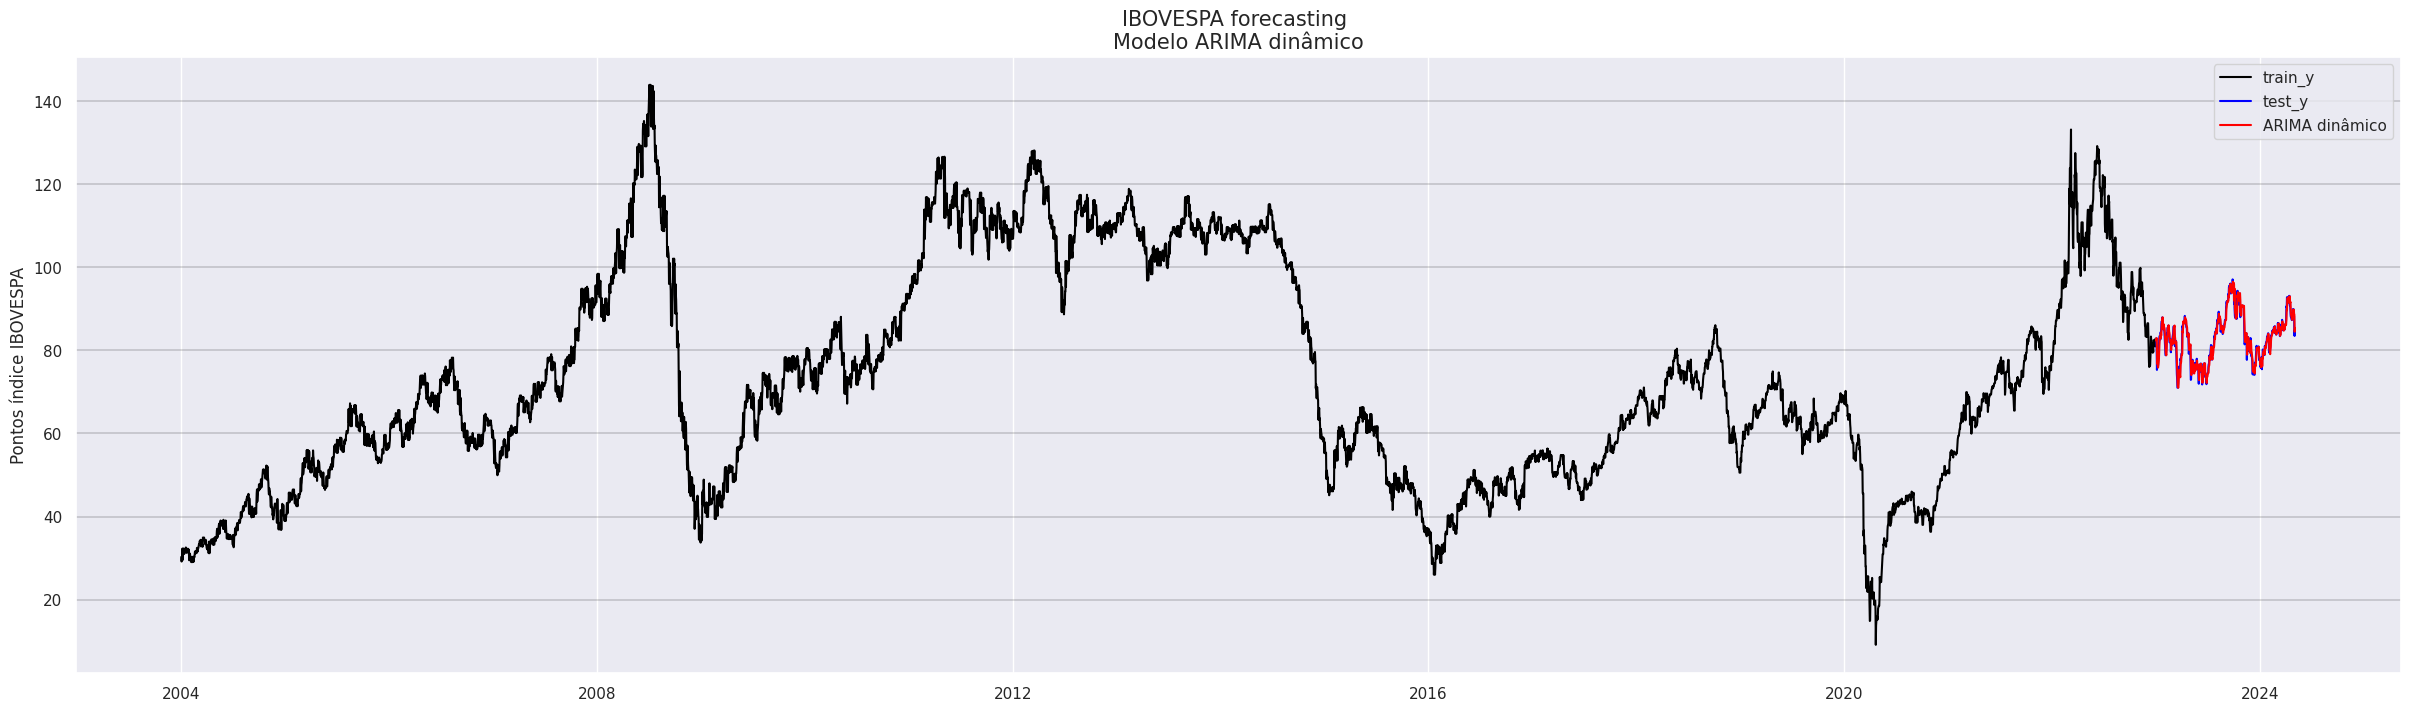

ARIMA dinâmico WMAPE: 1.21%
ARIMA dinâmico Test RMSE: 1.44
ARIMA dinâmico MAE: 1.01
ARIMA dinâmico MAPE: 0.01


In [92]:
model_ = 'ARIMA dinâmico'

fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(train_data_temporal, x='ds', y='y', ax=ax, label='train_y', color='black')
sns.lineplot(test_data_temporal, x='ds', y='y', ax=ax, color='blue', label='test_y')
sns.lineplot(y_pred, x='ds', y='y', ax=ax, color='red', label=f'{model_}')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title(f'IBOVESPA forecasting \nModelo {model_}', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

wmape_ = calc_wmape(test_data_temporal.y.values, y_pred.y.values)
rmse_ = sqrt(mean_squared_error(test_data_temporal.y.values, y_pred.y.values))
mae_ = calc_mae(test_data_temporal.y.values, y_pred.y.values)
mape_ = mean_absolute_percentage_error(test_data_temporal.y.values, y_pred.values)

print(f'{model_} WMAPE: {wmape_:.2%}')
print(f'{model_} Test RMSE: %.2f' % rmse_)
print(f'{model_} MAE: %.2f' % mae_)
print(f'{model_} MAPE: %.2f' % mape_)
df_modelos.loc[model_] = {'MAPE':mape_, 'WMAPE':wmape_, 'Accur':(1-mape_)}

## Validação dos Modelos

In [93]:
df_modelos.sort_values(by="Accur")

,MAPE,WMAPE,Accur
PROPHET,0.098566,0.085138,0.901434
SeasWA,0.059713,0.060771,0.940287
SeasonalNaive,0.057552,0.057817,0.942448
WindowAverage,0.057360,0.057636,0.942640
AutoARIMA,0.057211,0.057338,0.942789
ARIMA padrão,0.057189,0.057283,0.942811
Naive,0.057048,0.056924,0.942952
ARIMA dinâmico,0.012258,0.012114,0.987742


**Comentário:** De acordo com os estudos dos modelos de predição apresentados acima, o modelo escolhido como o melhor para continuar com as predições com um acurácia de 90% o modelo Prophet.

# Deploy Modelo

In [94]:
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(modelo_Prophet, f)

## Funções para Deploy

In [113]:
def carregarDF():
  df_modelo = pd.read_csv('https://raw.githubusercontent.com/Zoneti/fiap-postech-tech-challenge4/main/bases/modelo/df_modelo.csv', sep=";", parse_dates = [0], decimal = '.')
  df_modelo_10Anos = pd.read_csv('https://raw.githubusercontent.com/Zoneti/fiap-postech-tech-challenge4/main/bases/modelo/df_modelo_10.csv', sep=";", parse_dates = [0], decimal = '.')
  df_modelo.columns = ['ds', 'y']
  df_modelo_10Anos.columns = ['ds', 'y']

  return df_modelo, df_modelo_10Anos

In [118]:
def predict_Prophet(df, modelo, periodo):
  pred = pd.DataFrame(columns=['ds', 'y'])

  start_date = (df.ds.max() + pd.DateOffset(1)).to_pydatetime()
  pred_dates = pd.date_range(start=start_date, periods=periodo, freq='D')
  pred_df = pd.DataFrame(pred_dates, columns=['ds'])
  forecast = modelo.predict(pred_df)
  pred[['ds', 'y']] = forecast[['ds', 'yhat']]

  return pred

In [97]:
def plot_prev (ori, pred, dateLimit=None, test=None):
  fig, ax = plt.subplots(figsize=(30,8))

  if dateLimit is not None:
    ori = ori[ori['ds'] >= pd.to_datetime(dateLimit)]

  sns.lineplot(ori, x='ds', y='y', ax=ax, label='Preço Barril', color='black')

  if test is not None:
    sns.lineplot(test, x='ds', y='y', ax=ax, color='blue', label='Valor Teste')

  sns.lineplot(pred, x='ds', y='y', ax=ax, color='red', label='Valor Previsto')


  ax.grid(True, color='black', linewidth=0.2, axis='y')

  ax.legend()

  ax.set_title('Previsão Preço Barril Petroleo', fontsize=15)
  ax.set_xlabel('')
  ax.set_ylabel('Preço Barril Petroleo')

  plt.show()


In [98]:
# Carregar o modelo
with open('prophet_model.pkl', 'rb') as f:
    prophet_model = pickle.load(f)

In [114]:
df1, df2 = carregarDF()

In [115]:
previsao = pd.DataFrame(columns=['ds', 'y'])

In [119]:
previsao = predict_Prophet(df1, prophet_model, 5)

In [124]:
previsao.head()

,ds,y
0,2024-05-04,83.852127
1,2024-05-05,83.832010
2,2024-05-06,83.888578
3,2024-05-07,83.800005
4,2024-05-08,83.703428


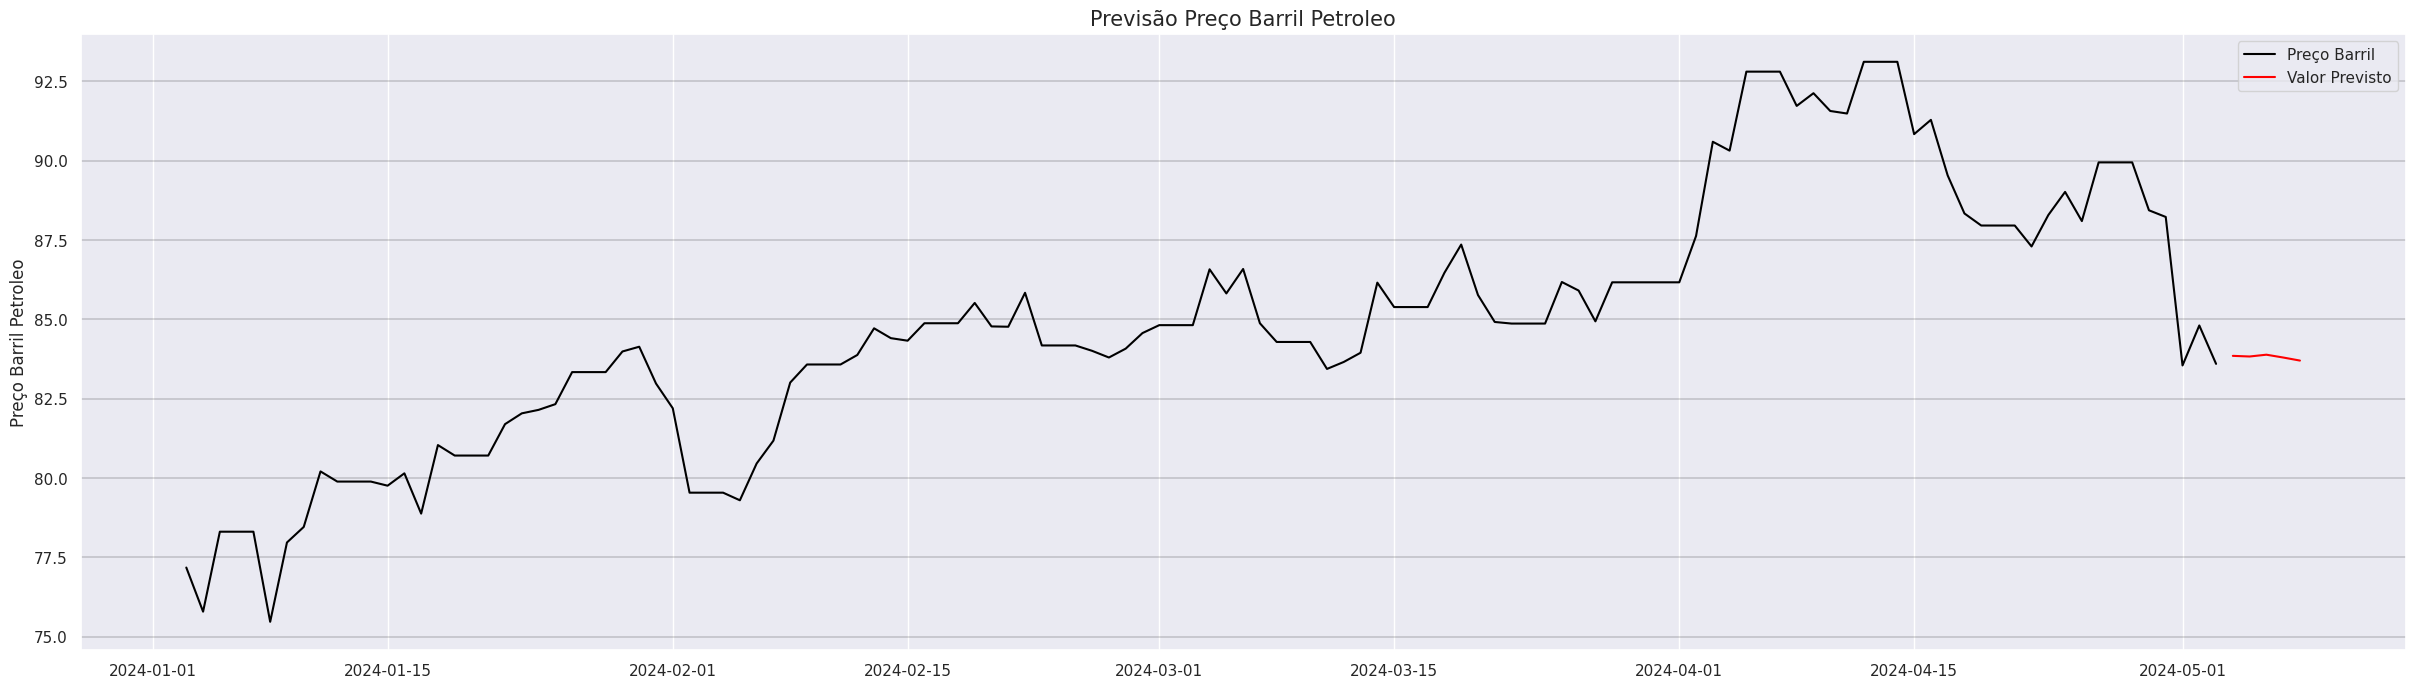

In [123]:
plot_prev(df1, previsao, '01-03-2024')